In [27]:
from PIL import Image # get the image
import cv2 as cv 
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 12]

In [28]:
"""
Parameters used for OpenCv functions
We can find these by playing with the dashboard
"""
gaussian_w = 5 # width of the gaussian filter
gaussian_h = 5 # height of the gaussian filter
sigmaX = 5 # review what this does
canny_minval = 100 # refers to strength of edges
canny_maxval = 200
canny_aperature = 3 # this is the size of the sobel kernel, review sobel kernels


## 1. Get picture of current board

In [29]:
img_path = "../data/nashirBoard.JPG" # testing with Nashirs board
orig_img = np.array(Image.open(img_path)) # need to convert image into a numpy array

scale_percent = 20 # percent of original size
width = int(orig_img.shape[1] * scale_percent / 100)
height = int(orig_img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
img = cv.resize(orig_img, dim, interpolation = cv.INTER_AREA)

# img = orig_img

print(img.shape)

(604, 806, 3)


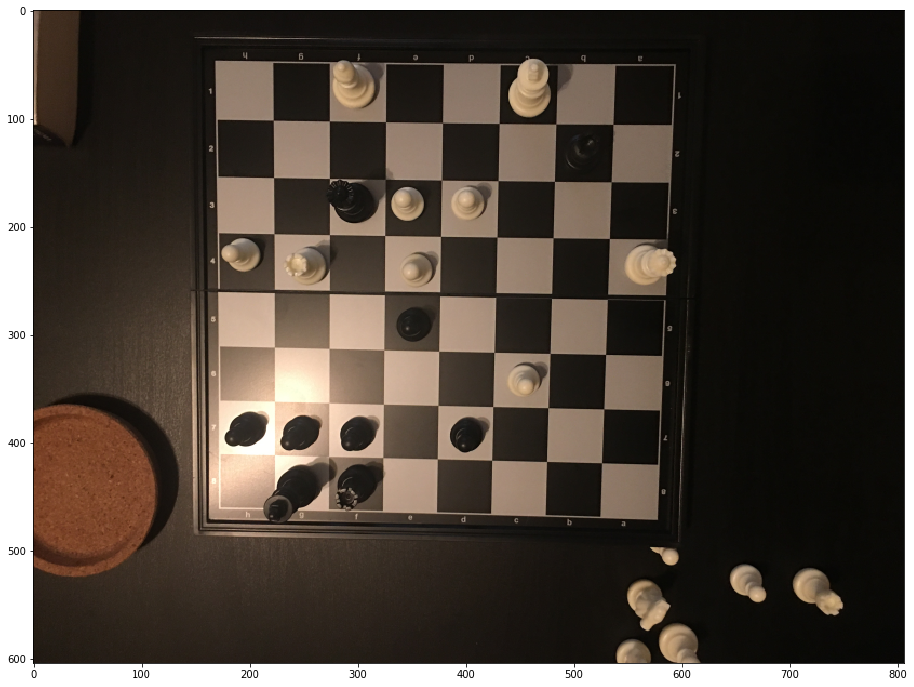

In [30]:
plt.imshow(img)

## 2. Edge detection

In [31]:
gray_img = cv.cvtColor(img,cv.COLOR_BGR2GRAY) # convert to gray scale, easier to detect with a gray scale image
blur_img  = cv.GaussianBlur(gray_img,(gaussian_w,gaussian_h),sigmaX) # blurring is important for removing noise

In [32]:
canny_edges = cv.Canny(blur_img,canny_minval,canny_maxval,canny_aperature) #finds the edges of the image using canny

## 3. Line detection

In [33]:
hough_lines = cv.HoughLines(canny_edges,1,np.pi/180,150, None, 0, 0) ## review paramters here for drawing the lines

In [34]:
def draw_lines(img, hough_lines):
    out_img = img.copy()
    # code from opencv to draw lines found from hough transform on an image
    for i in range(0, len(hough_lines)):
        rho = hough_lines[i][0][0]
        theta = hough_lines[i][0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

        out_img = cv.line(out_img, pt1, pt2, (255,255,255), 2, cv.LINE_AA)
    return out_img

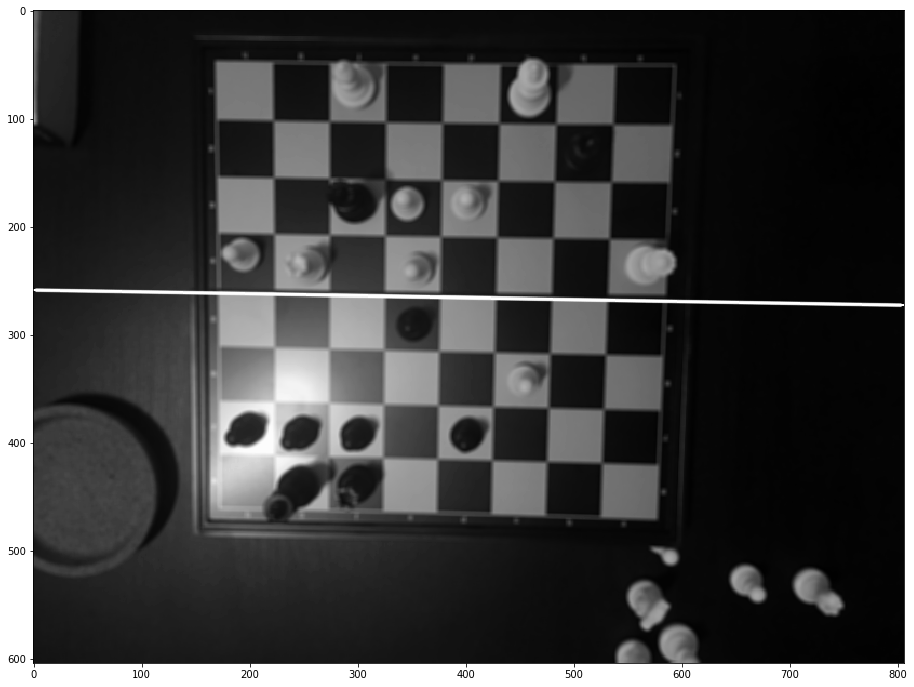

In [35]:
img_w_lines = draw_lines(blur_img, hough_lines)
# show the image
plt.imshow(img_w_lines, cmap='gray')

## 4. Compute line intersection points

## 5. Find corners of the chess board

#### Using Harris Corner Detector

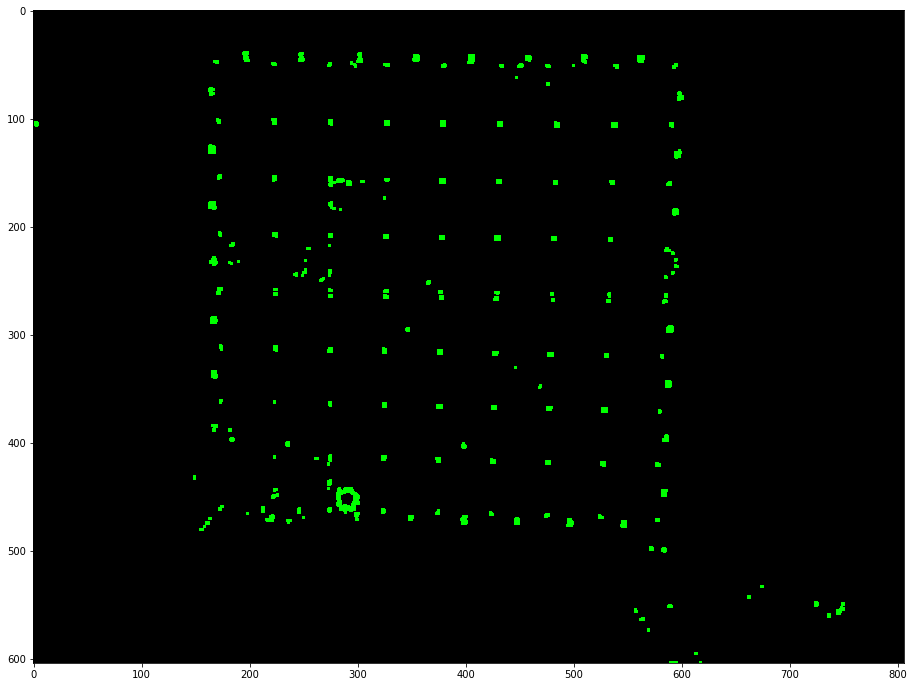

In [36]:
# filename = 'chessboard.png'
# img = cv.imread(filename)
corners_img = img.copy()
gray = cv.cvtColor(corners_img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv.cornerHarris(gray,2,3,0.04)
#result is dilated for marking the corners, not important
dst = cv.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
corners_img[dst>0.01*dst.max()]=[0,255,0]
corners_img[dst<=0.01*dst.max()]=[0,0,0]
# cv.imshow('dst',img)
# if cv.waitKey(0) & 0xff == 27:
#     cv.destroyAllWindows()
plt.imshow(corners_img)

#### Using find chessboard corners

corners is None


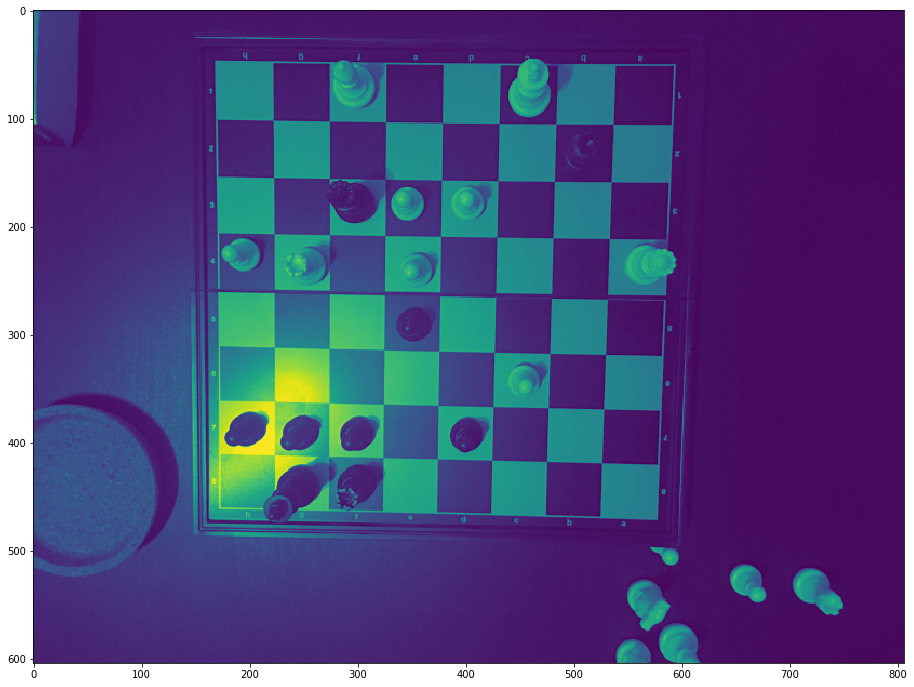

In [37]:
nline = 7
ncol = 7

## processing
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

plt.imshow(gray)

# Find the chessboard corners
ret, corners = cv.findChessboardCorners(gray, (nline, ncol), None)
if ret:
    corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
    plt.imshow(corners2)
else:
    print("corners is None")

#### Hard code image corners

[168  46]
[593  51]
[172 460]
[578 472]


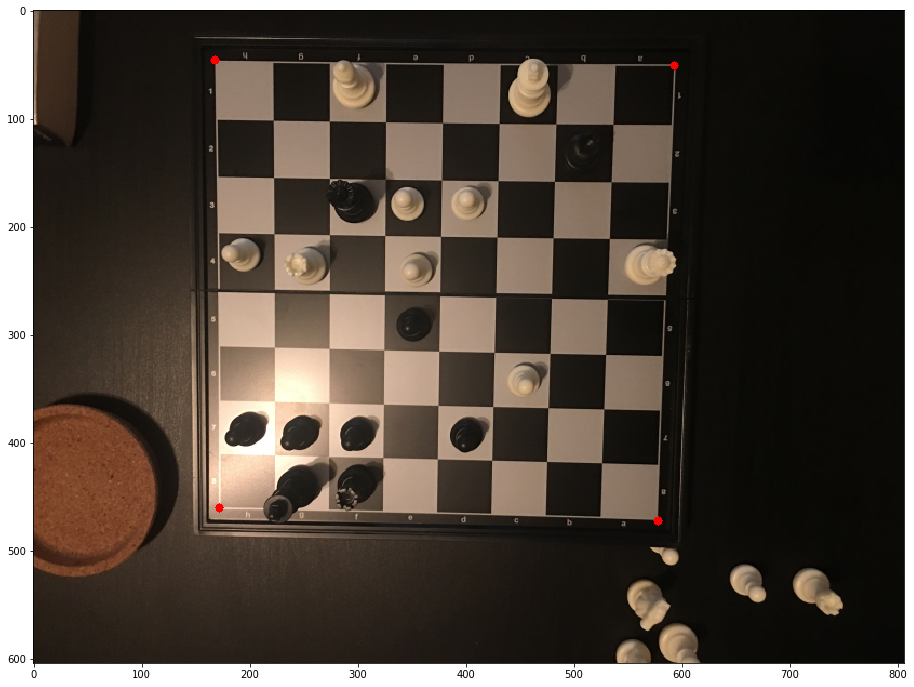

In [82]:
corners = np.array([(168,46), (593,51), (172,460), (578,472)])
circle_img = img.copy()
for corner in corners:
    circle_img = cv.circle(circle_img, corner, 4, (255, 0, 0), -1)
plt.imshow(circle_img)

## 6. Compute transformation matrix from corners to constant image dimension (e.g. 800x800)

In [76]:
import transform

In [104]:
trans_img = transform.four_point_transform(img, transform.order_points(np.array(corners)))

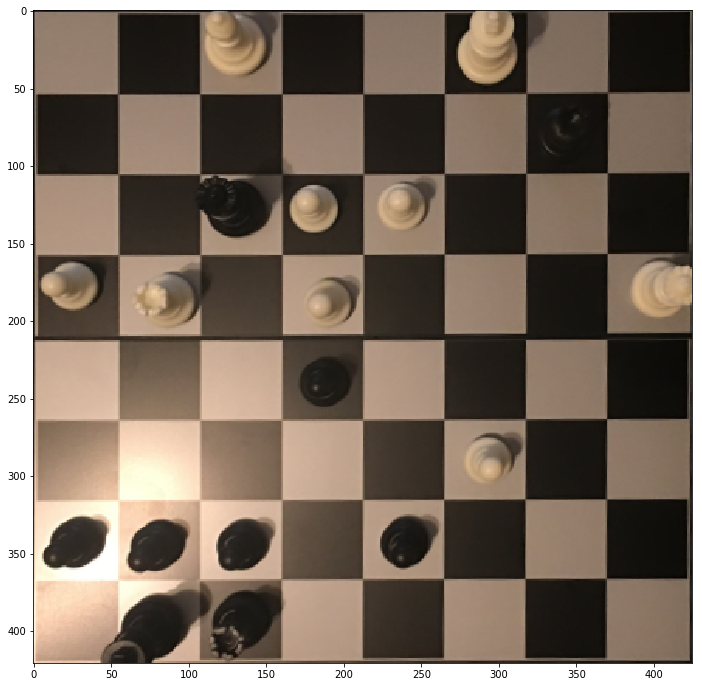

In [105]:
plt.imshow(trans_img)

## 7. Transform/crop/resize image based on transformation matrix

In [106]:
dim = (800, 800)
reduc_trans_img = cv.resize(trans_img, dim, interpolation = cv.INTER_AREA)

## 8. Segment board into 64 squares

In [108]:
squaresize = int(dim[0] / 8)
squares = [[None for _ in range(8)] for _ in range(8)]
for i in range(8):
    for j in range(8):
        squares[i][j] = reduc_trans_img[i * squaresize: (i + 1) * squaresize, j * squaresize: (j + 1) * squaresize, :]

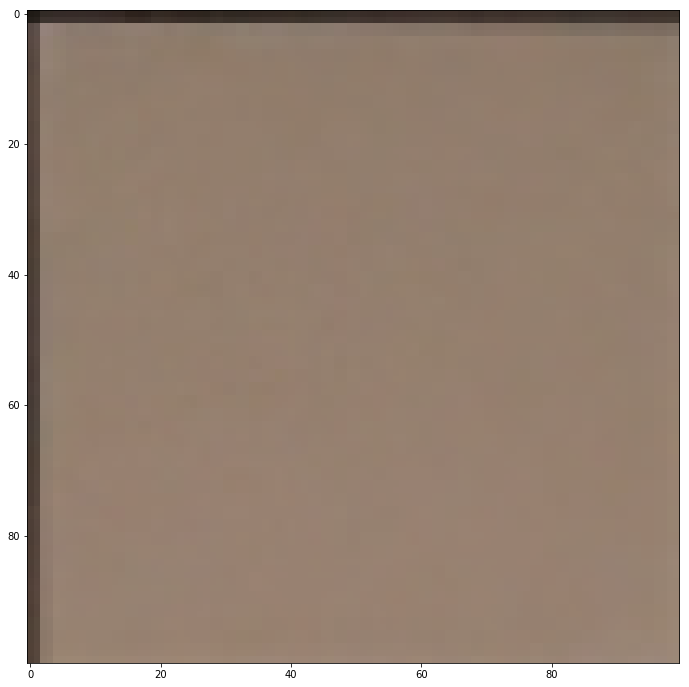

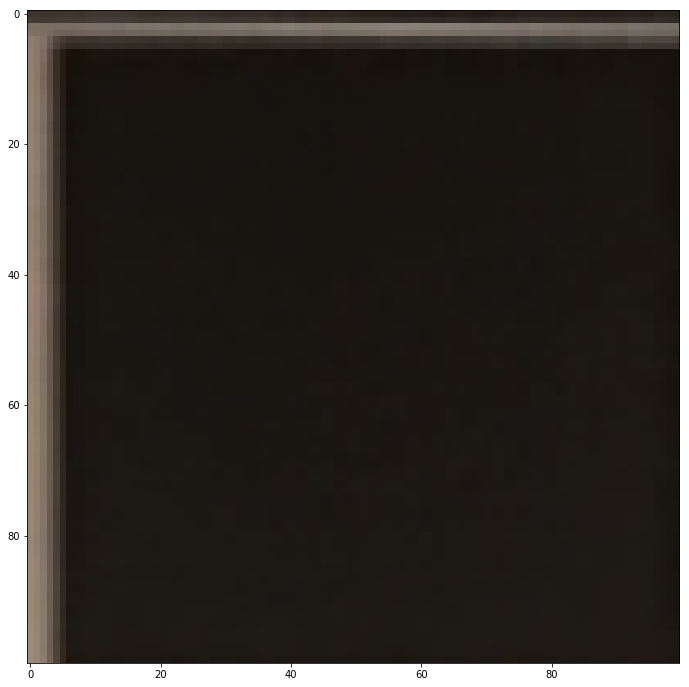

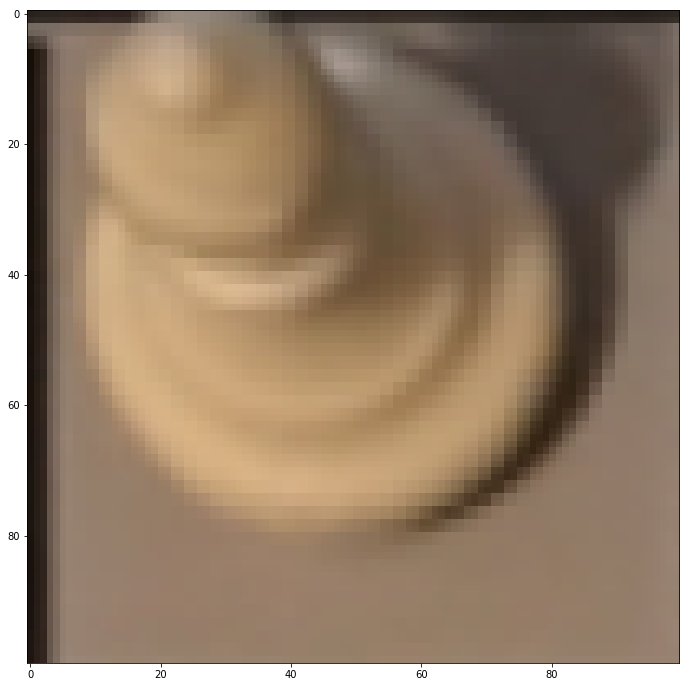

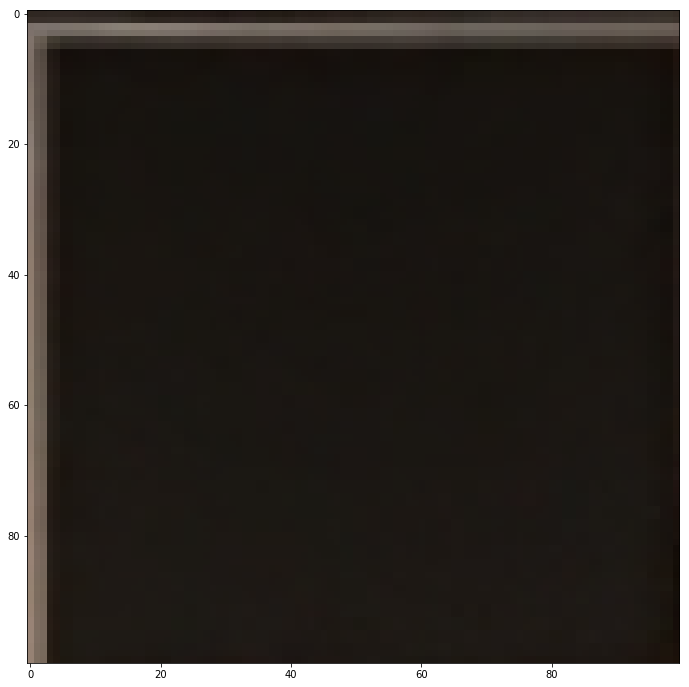

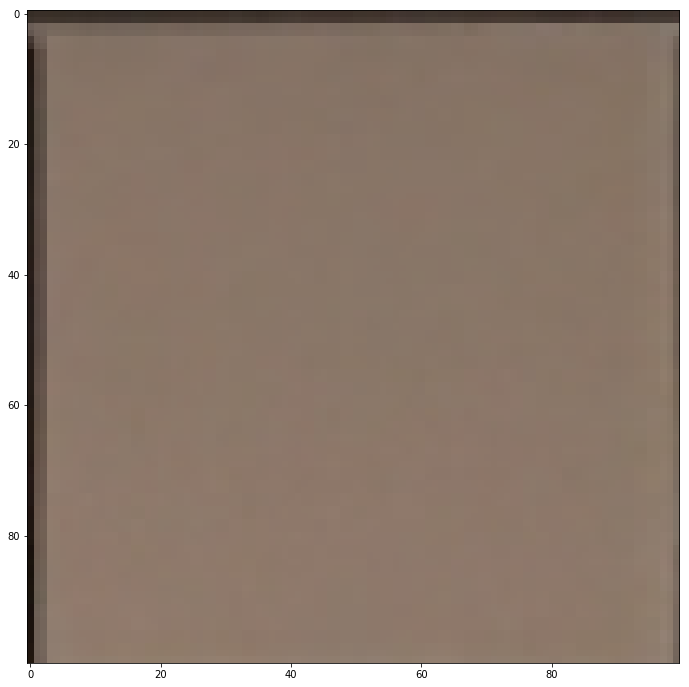

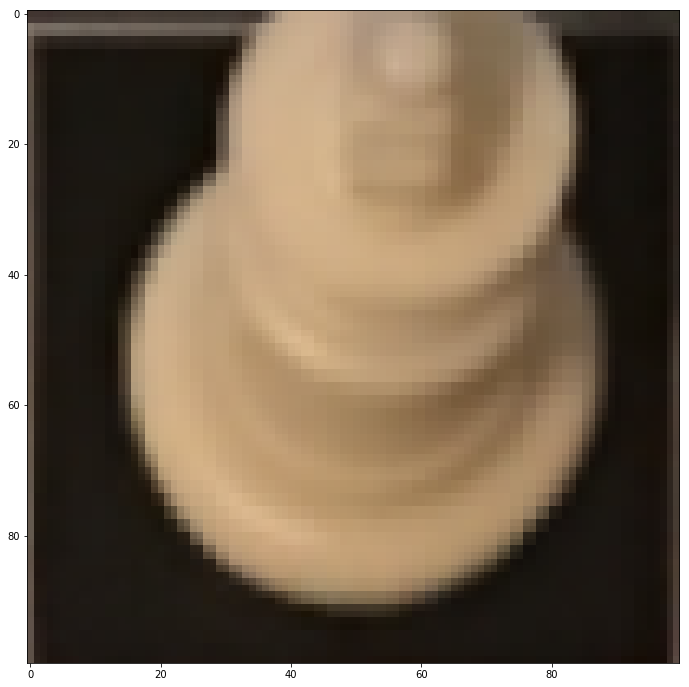

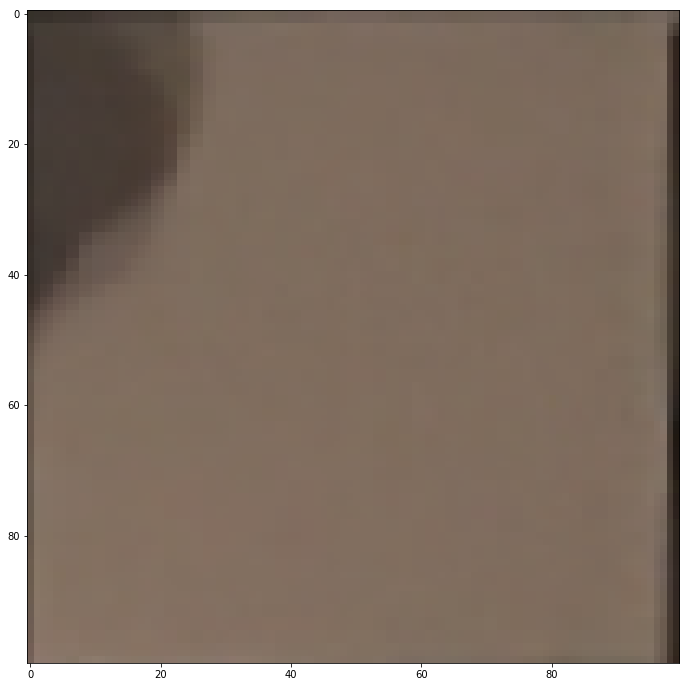

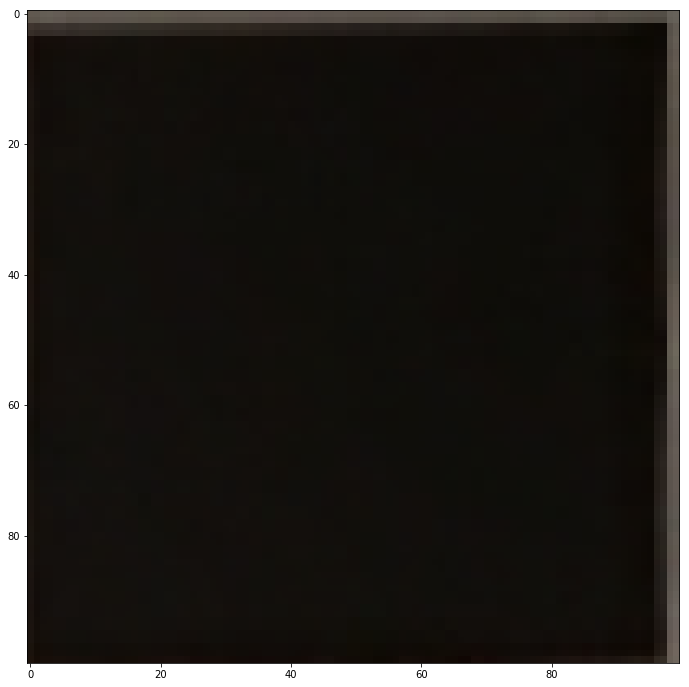

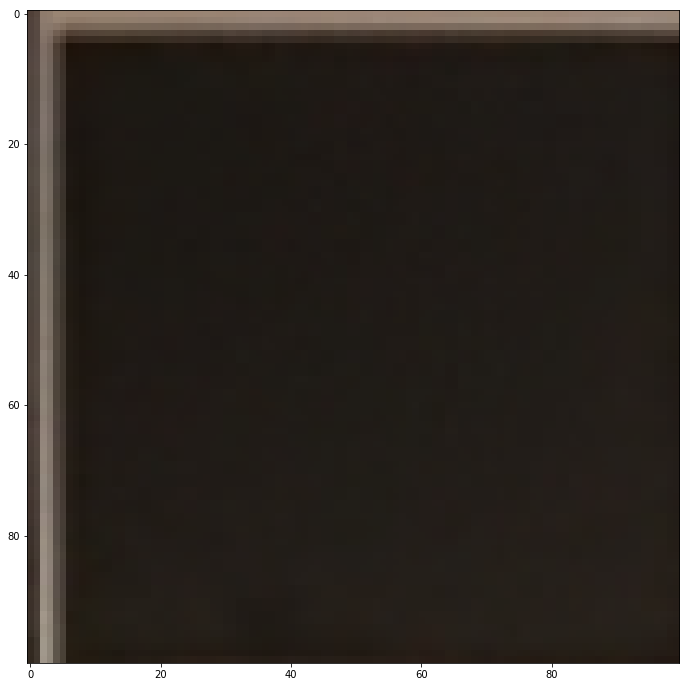

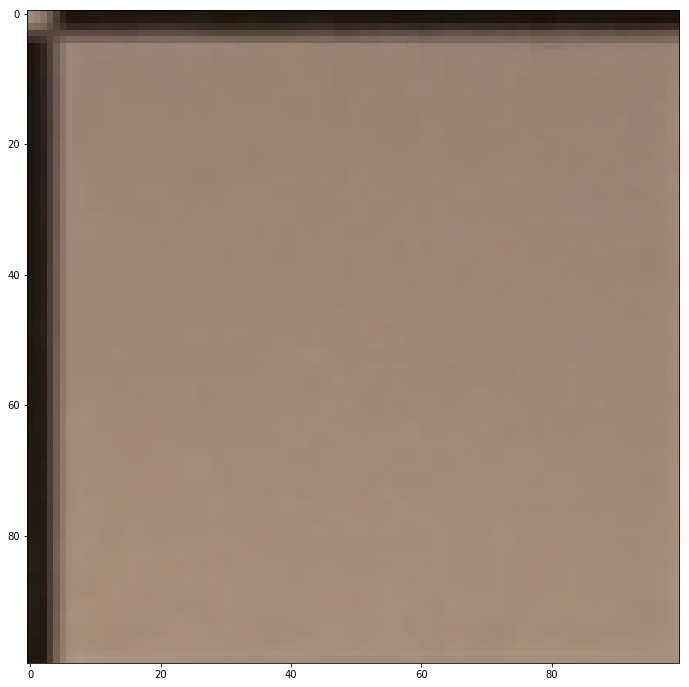

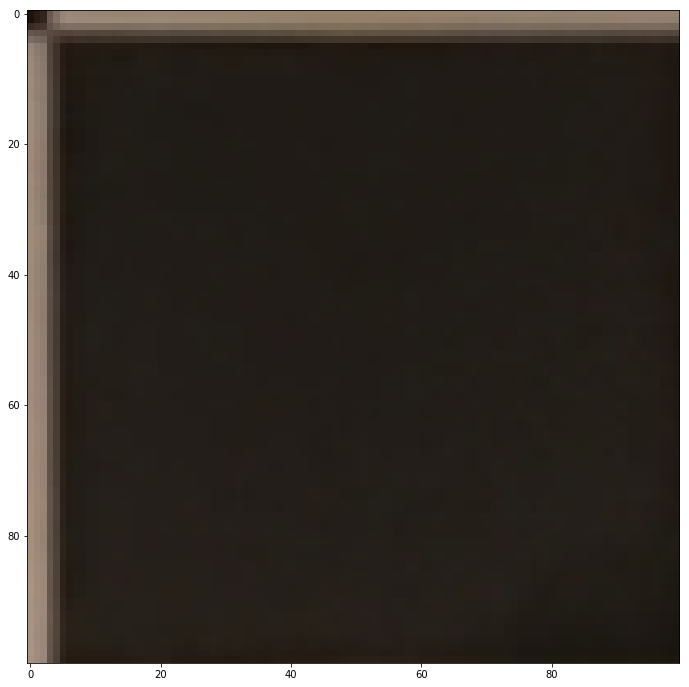

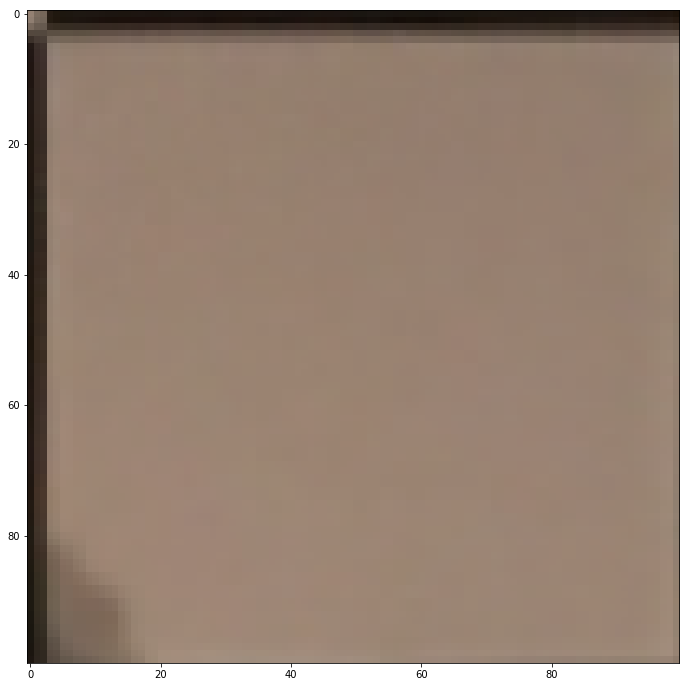

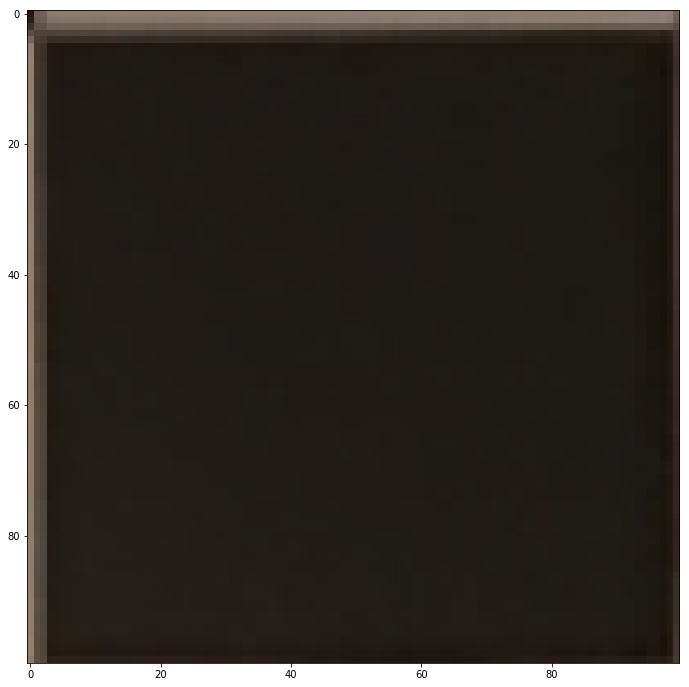

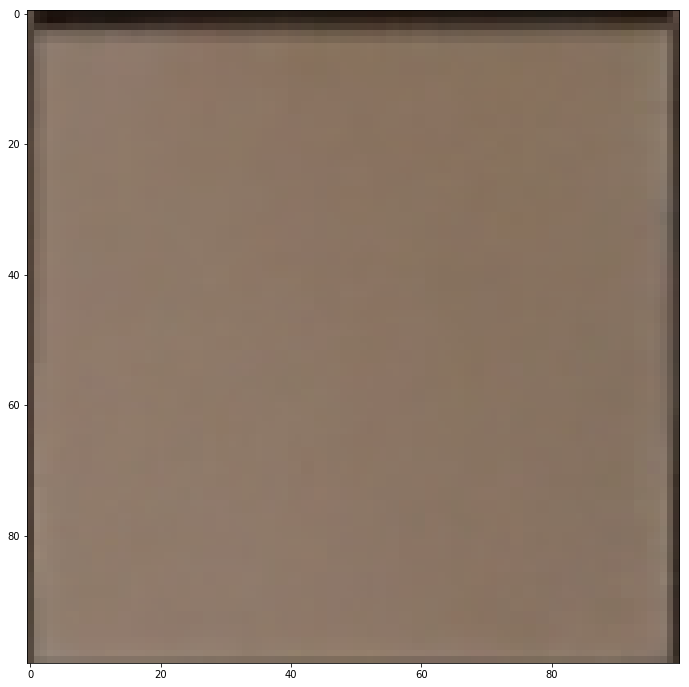

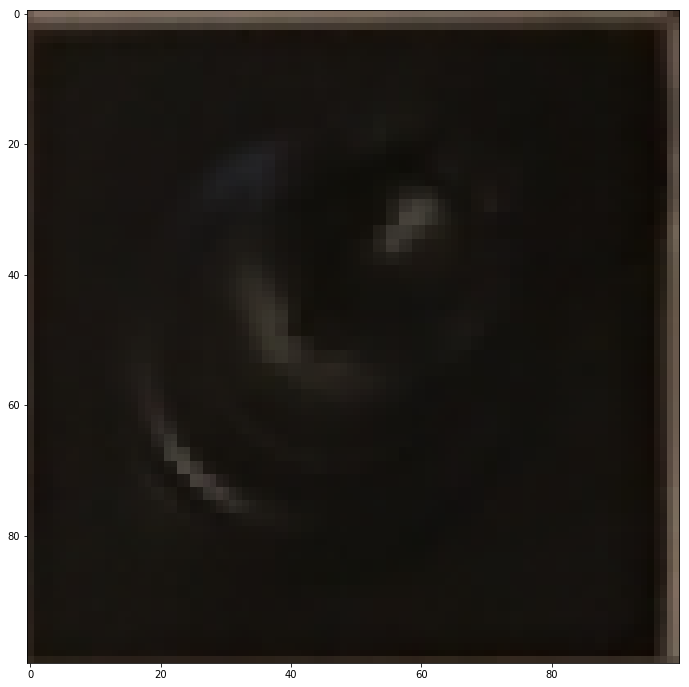

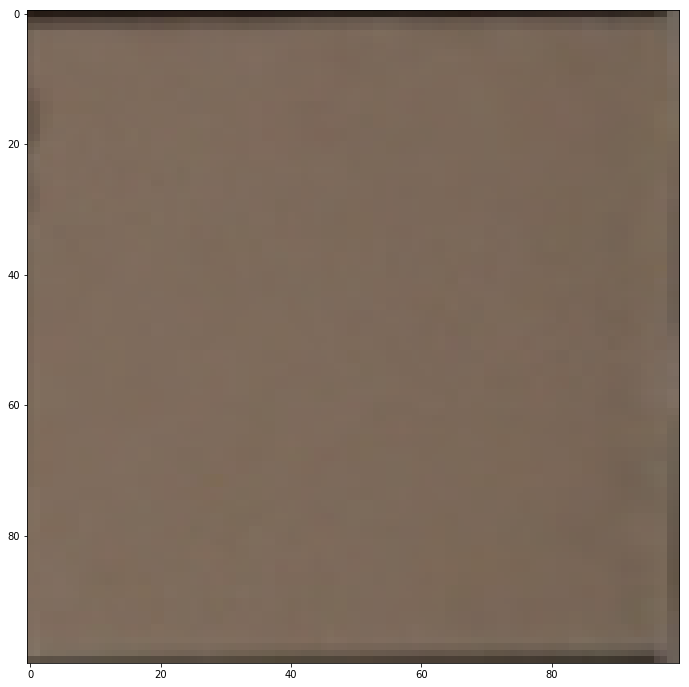

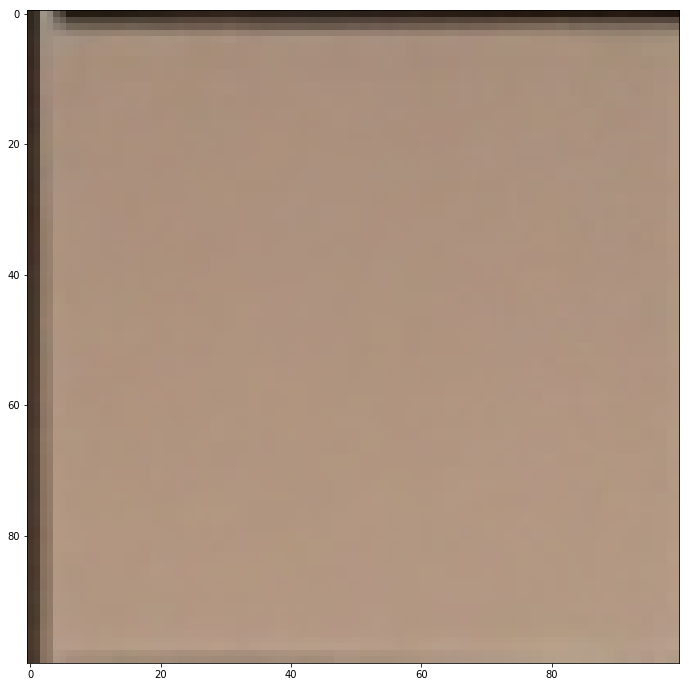

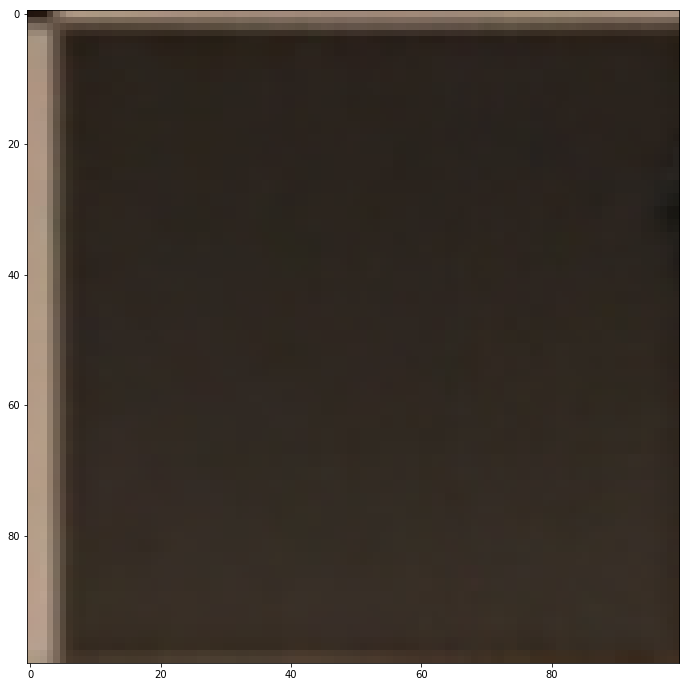

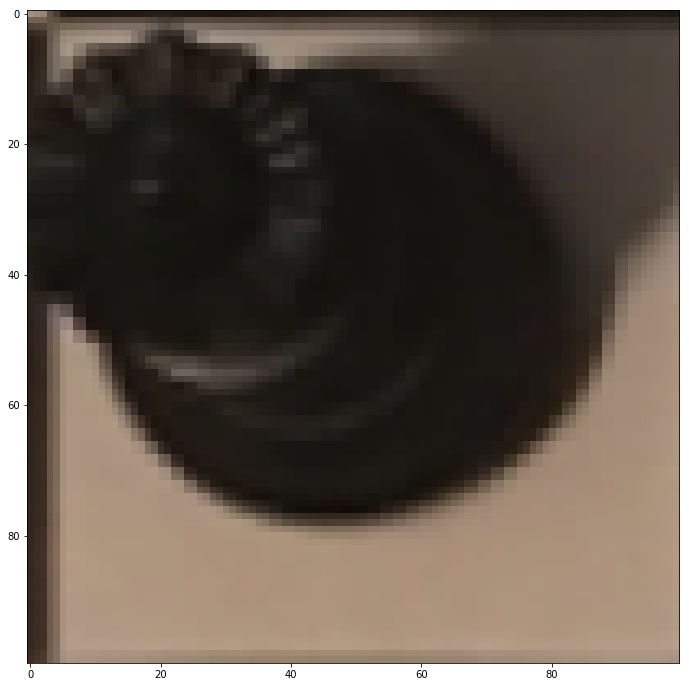

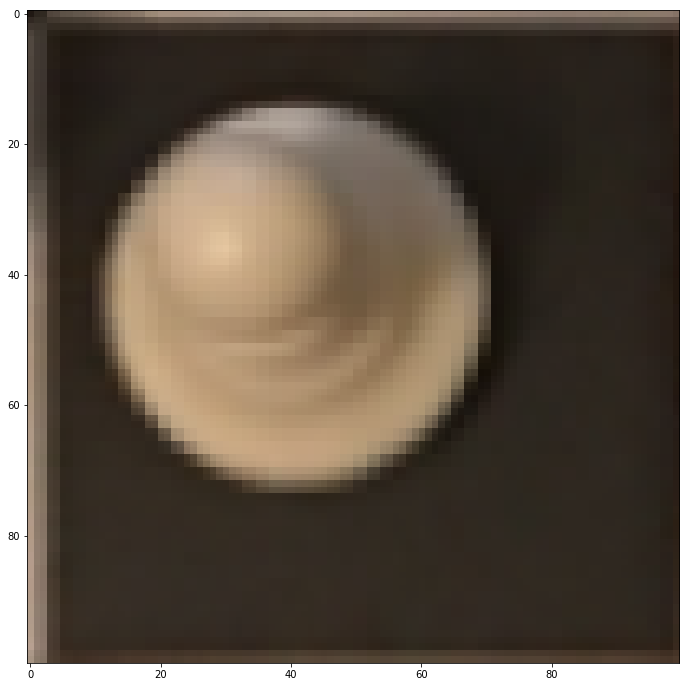

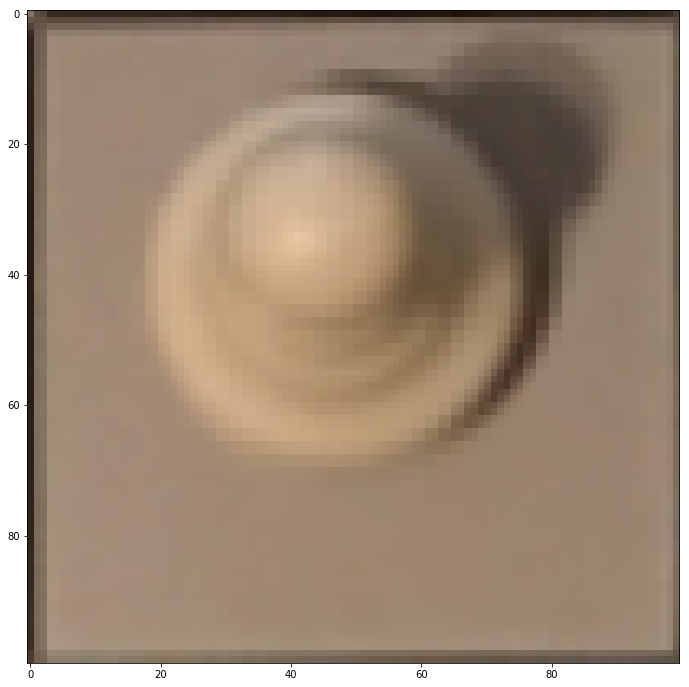

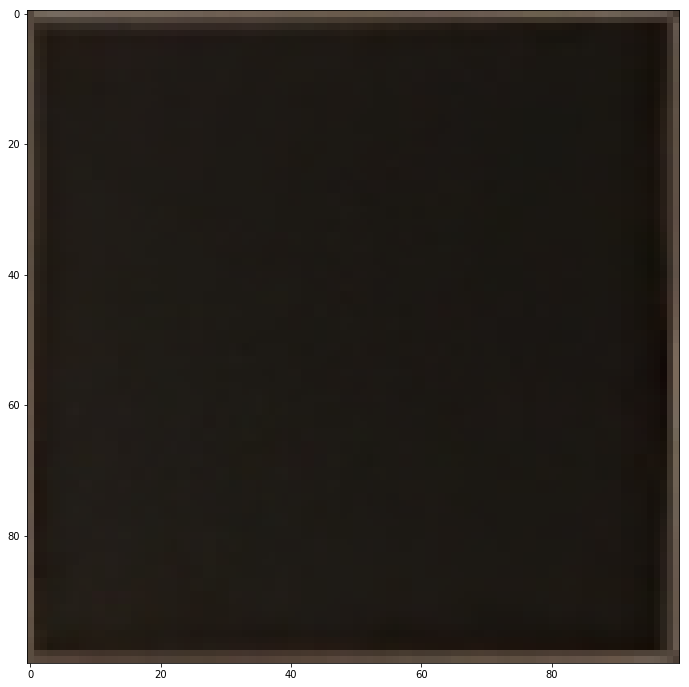

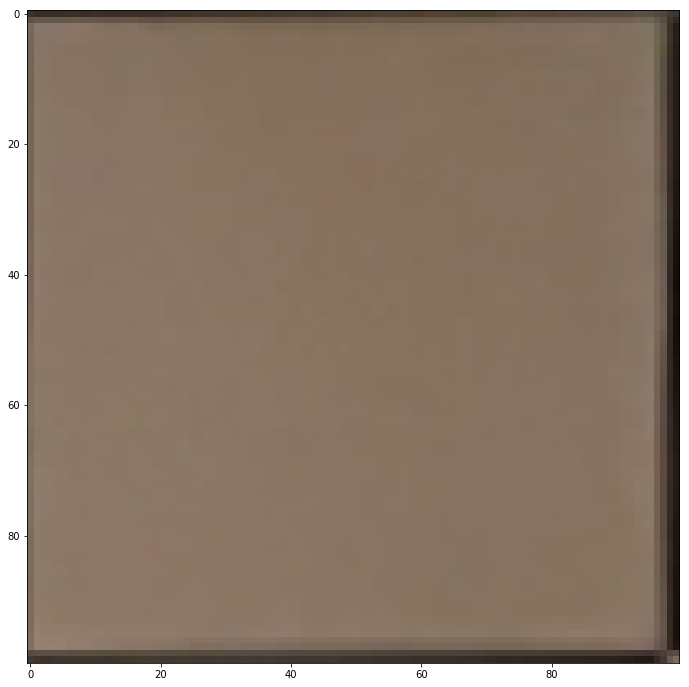

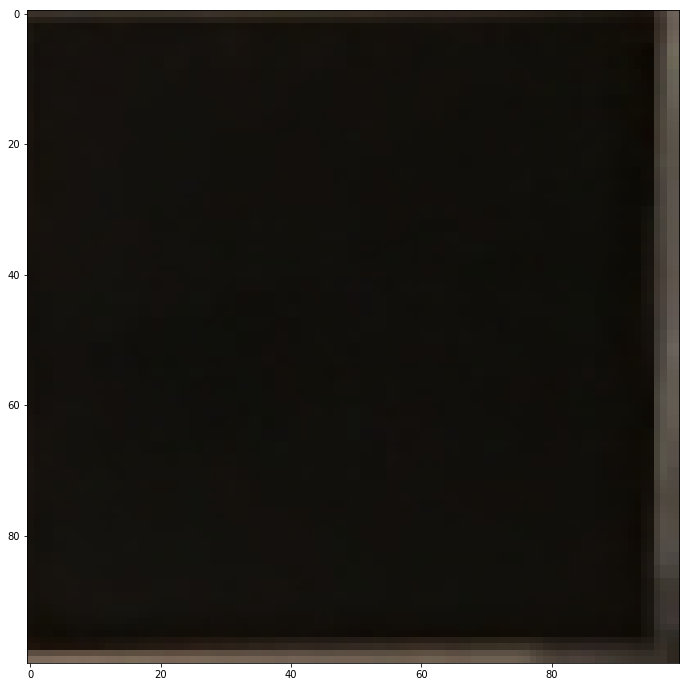

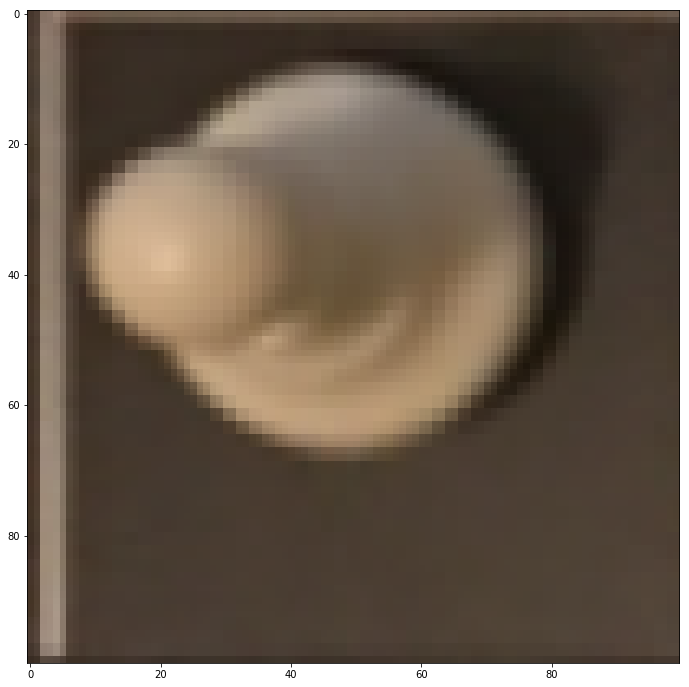

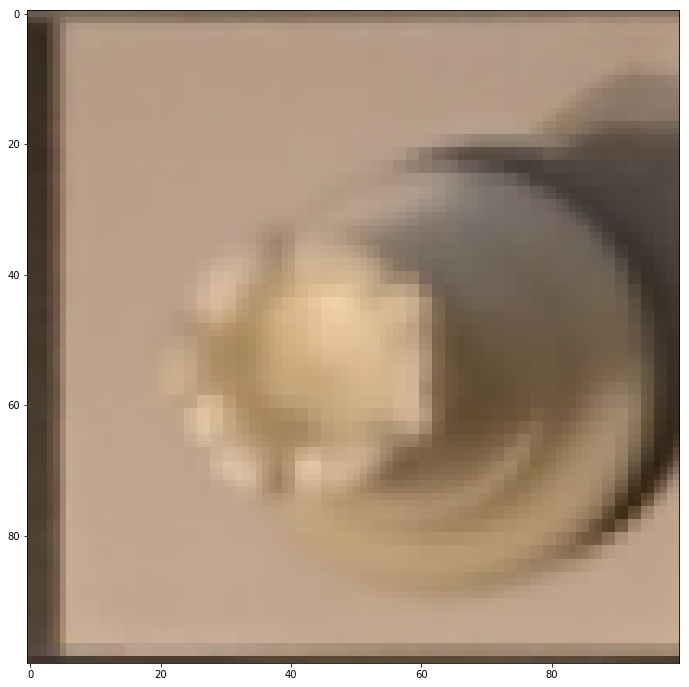

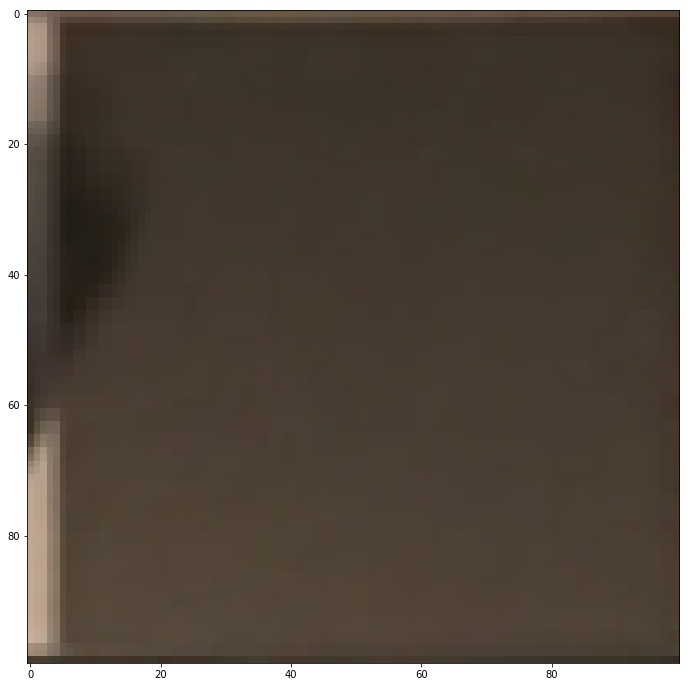

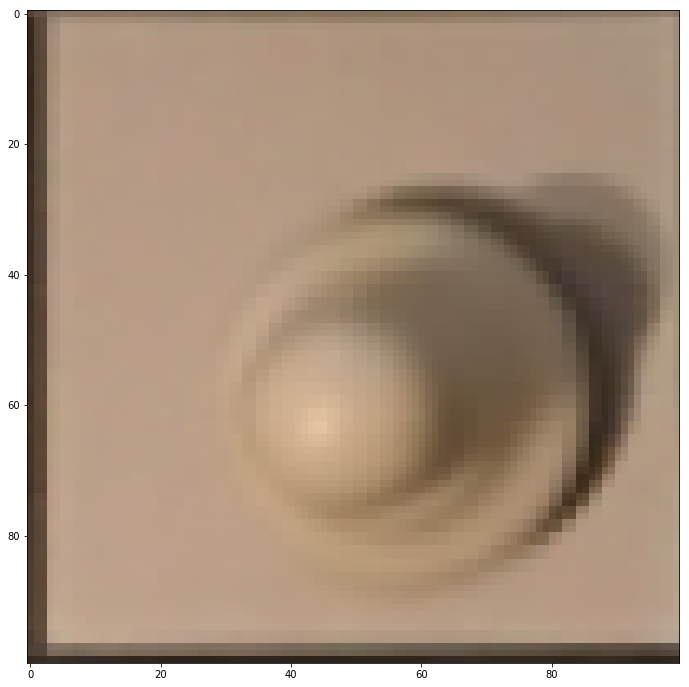

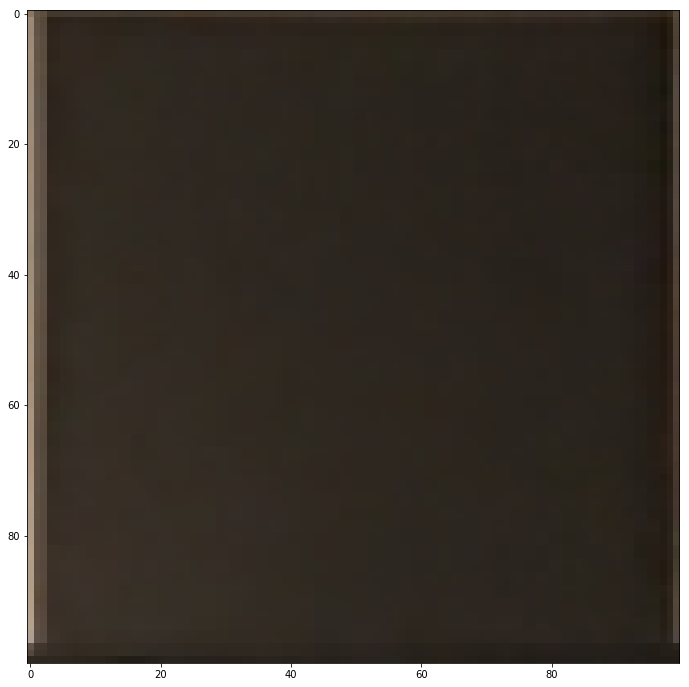

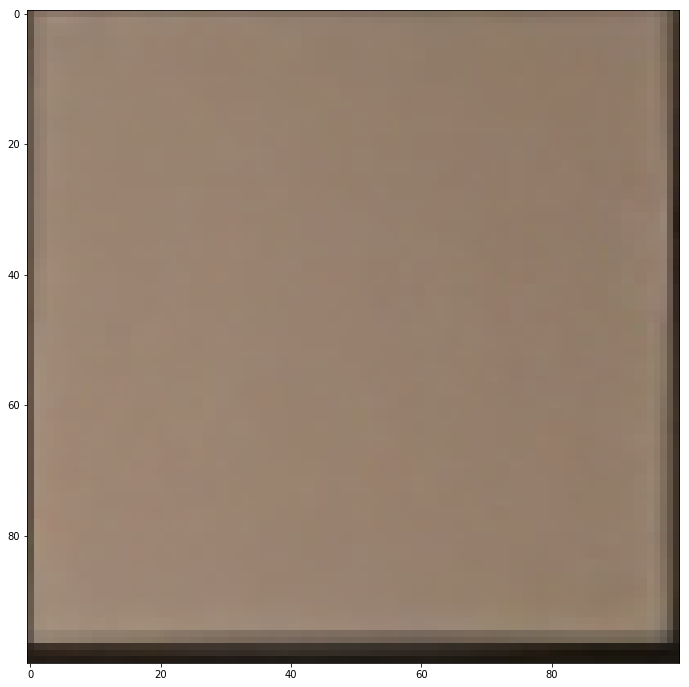

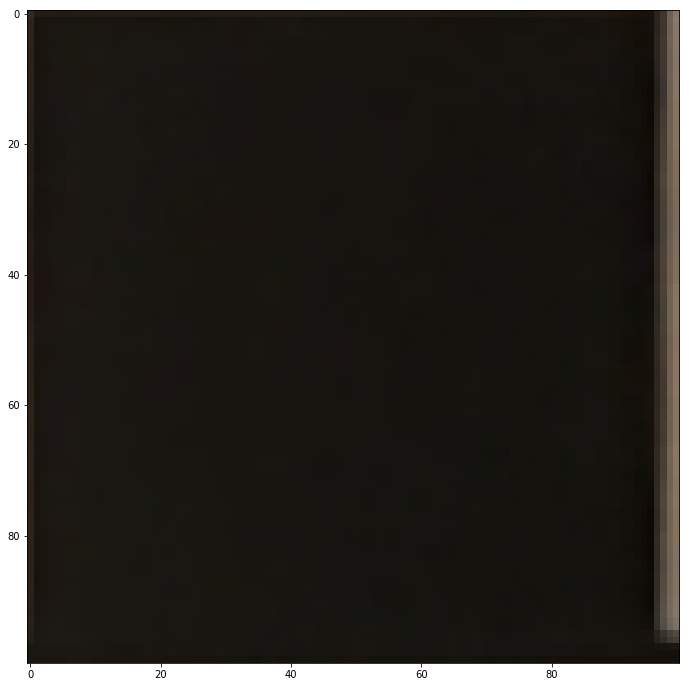

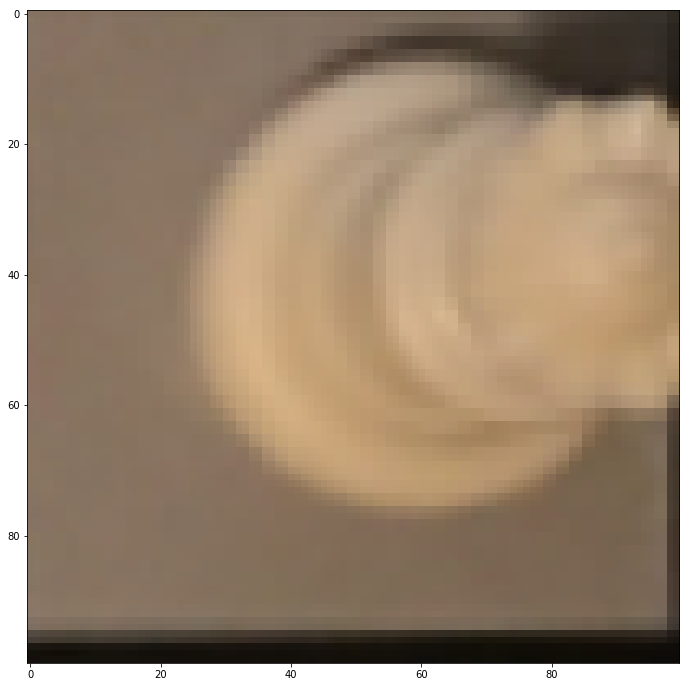

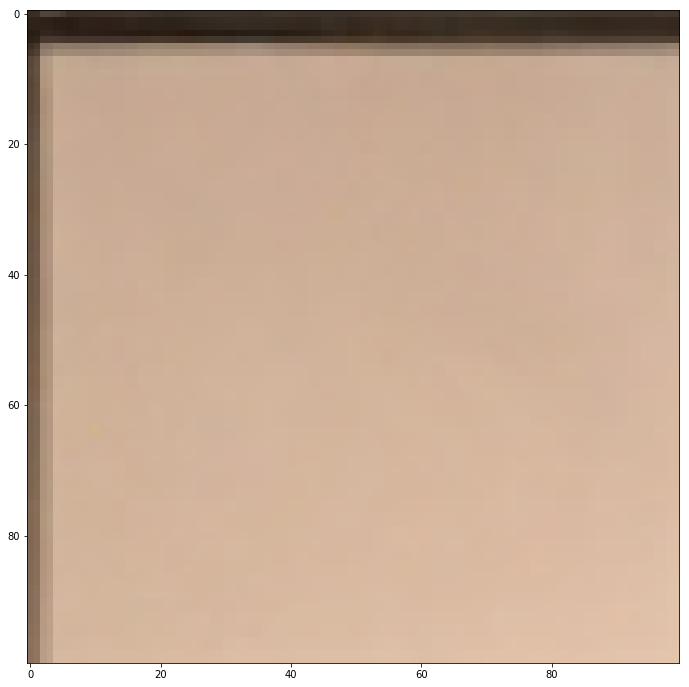

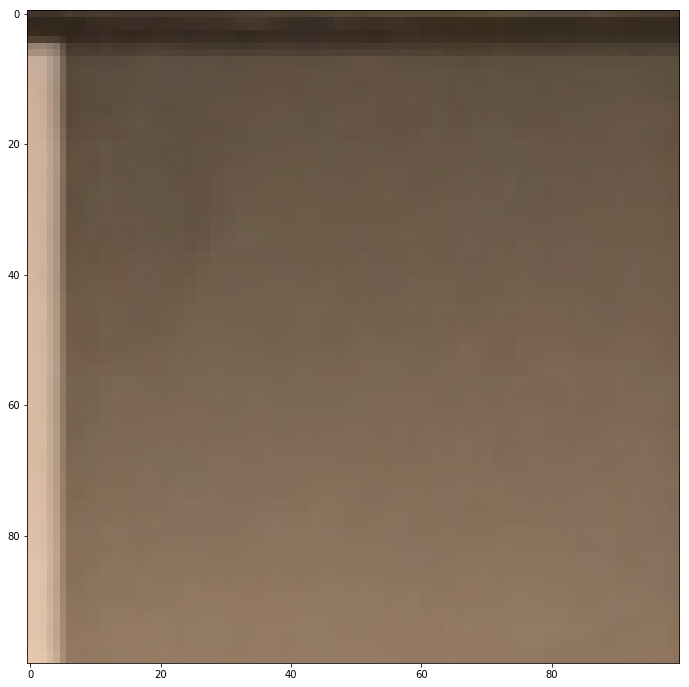

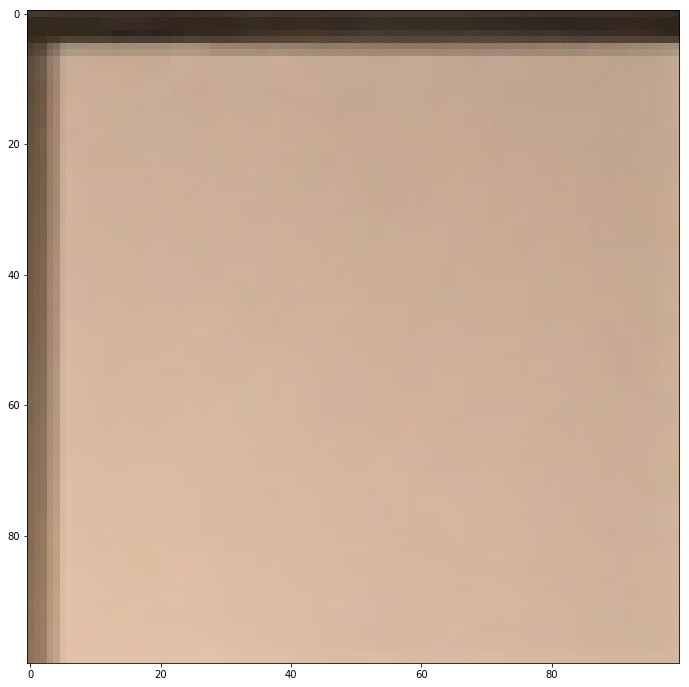

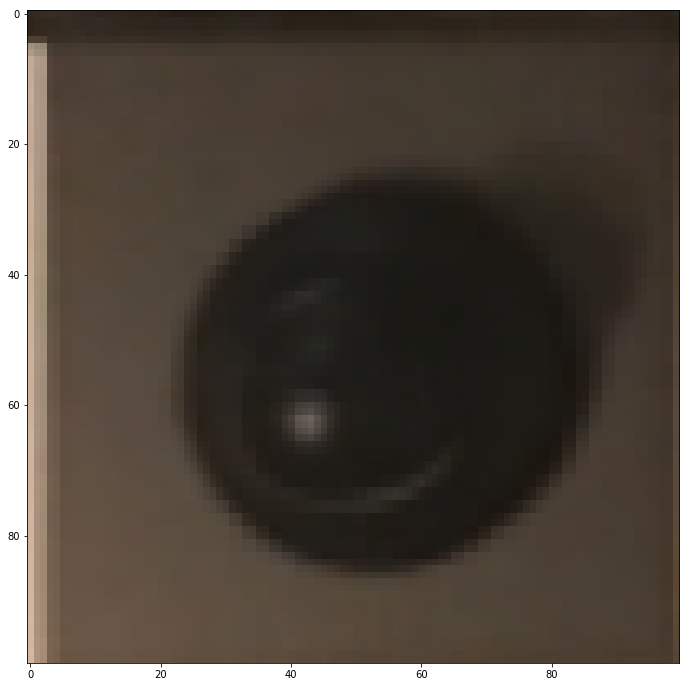

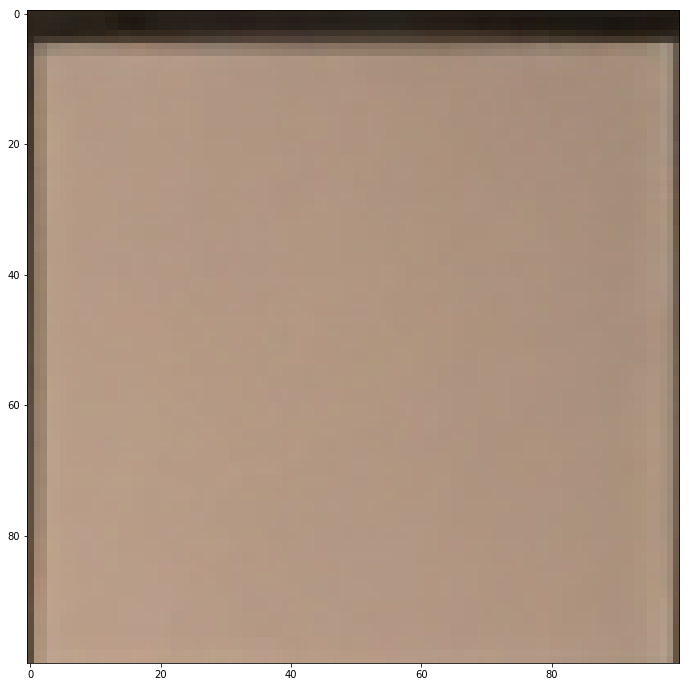

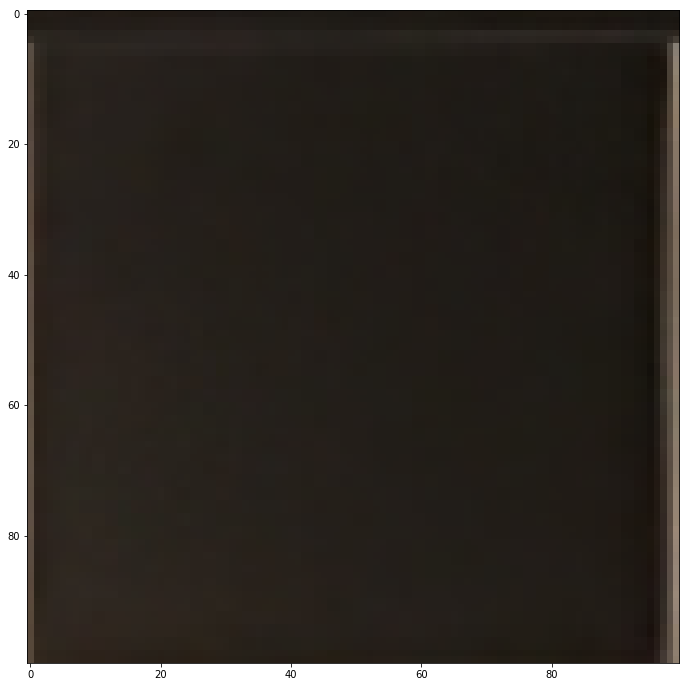

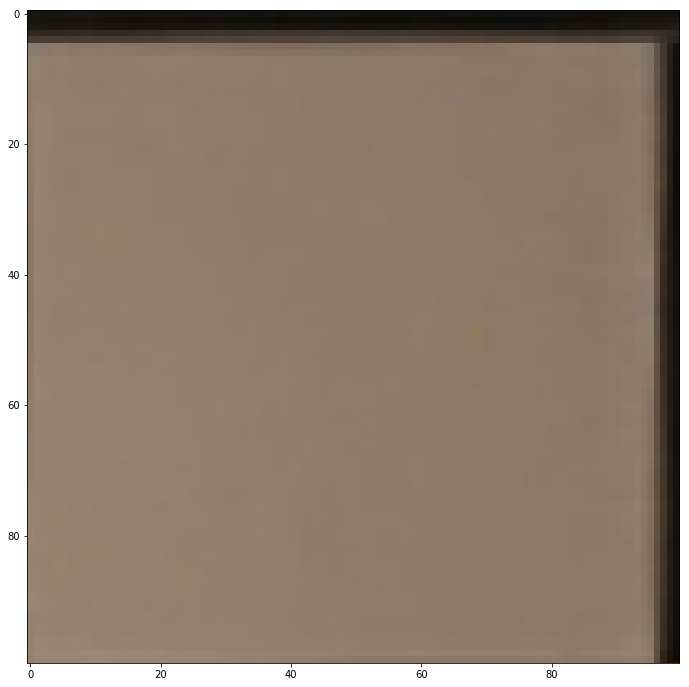

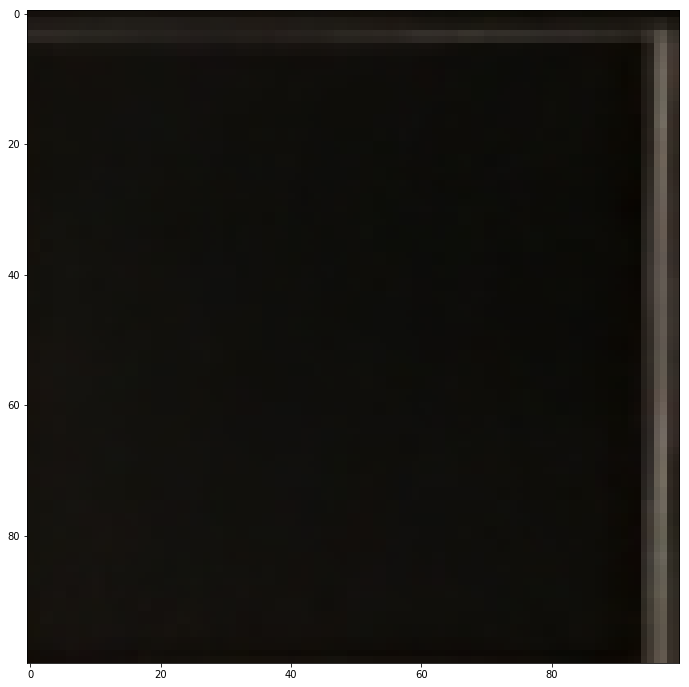

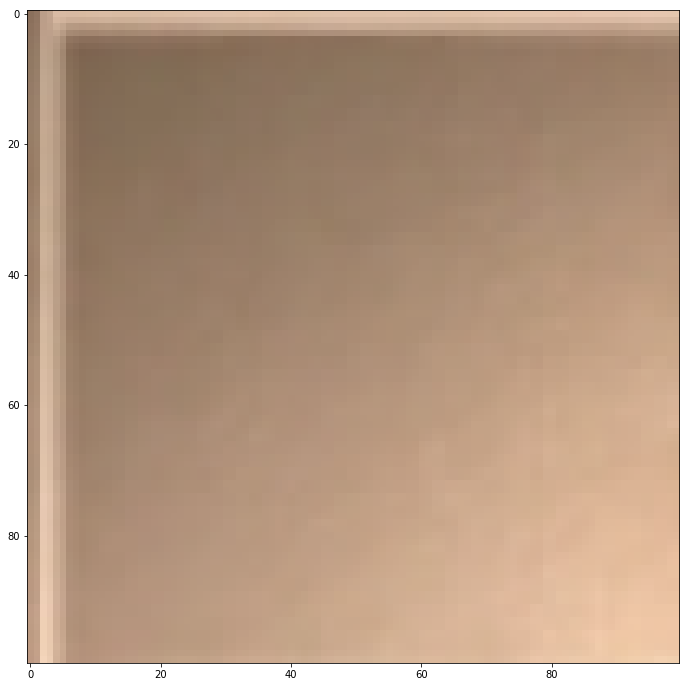

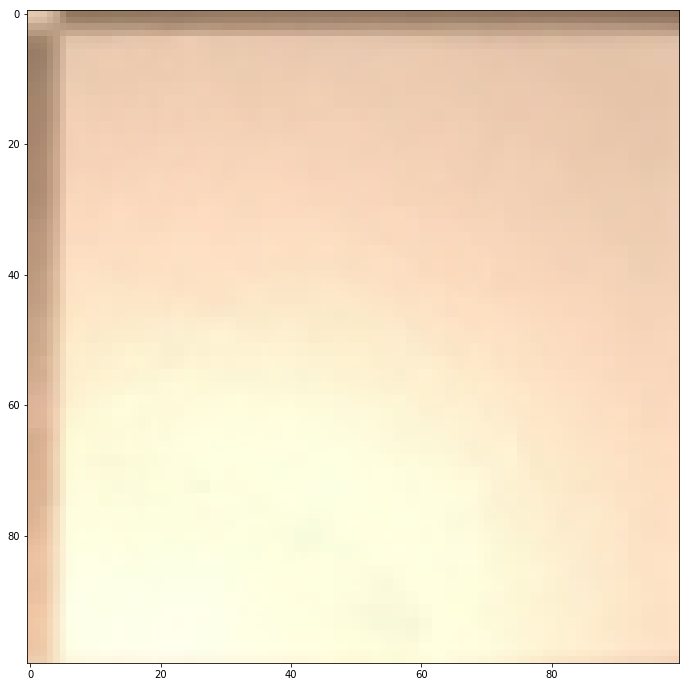

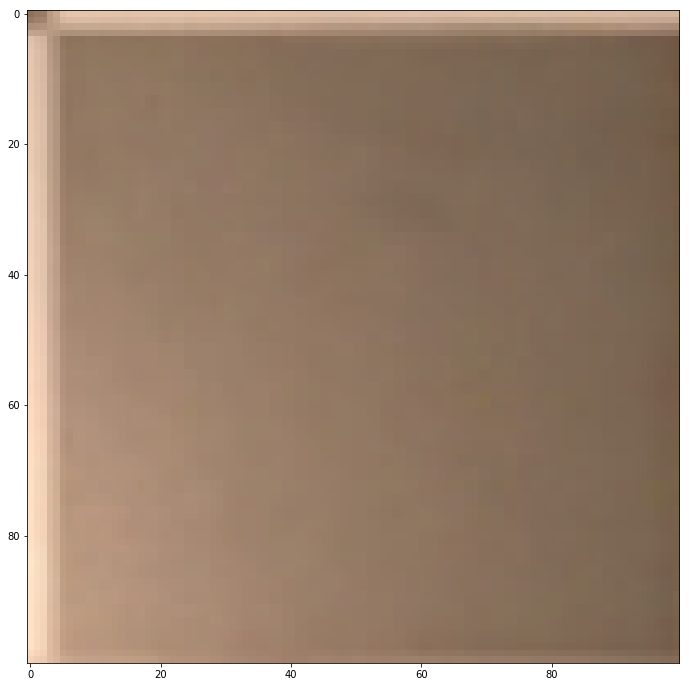

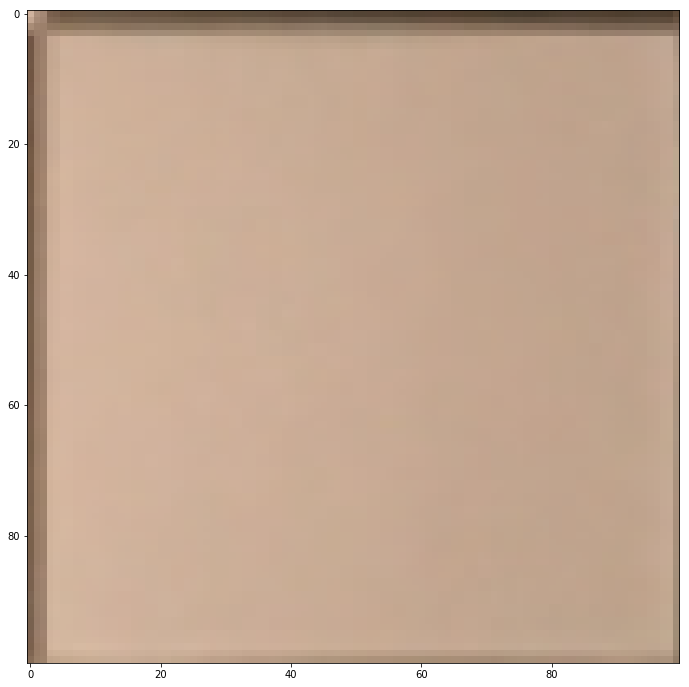

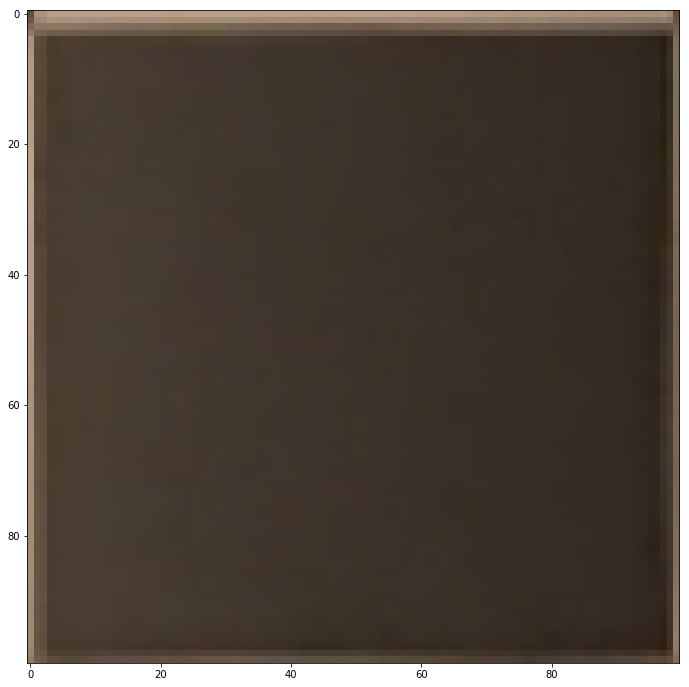

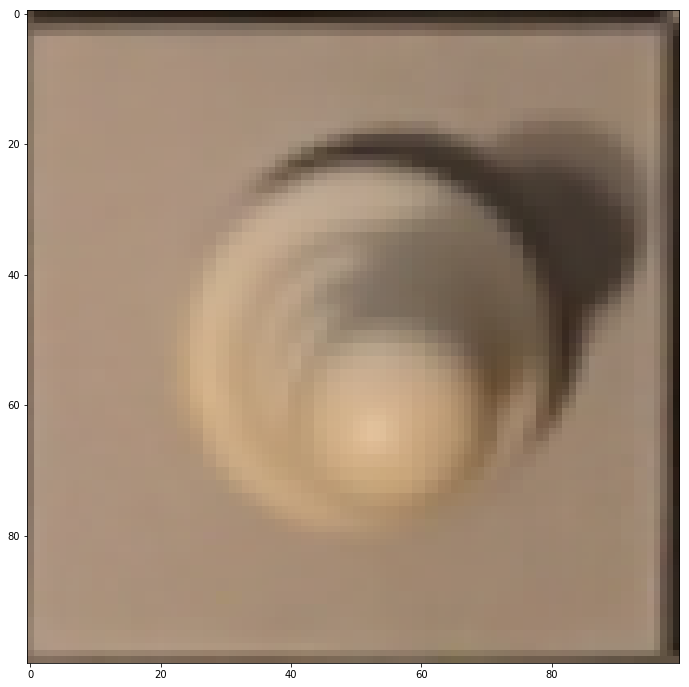

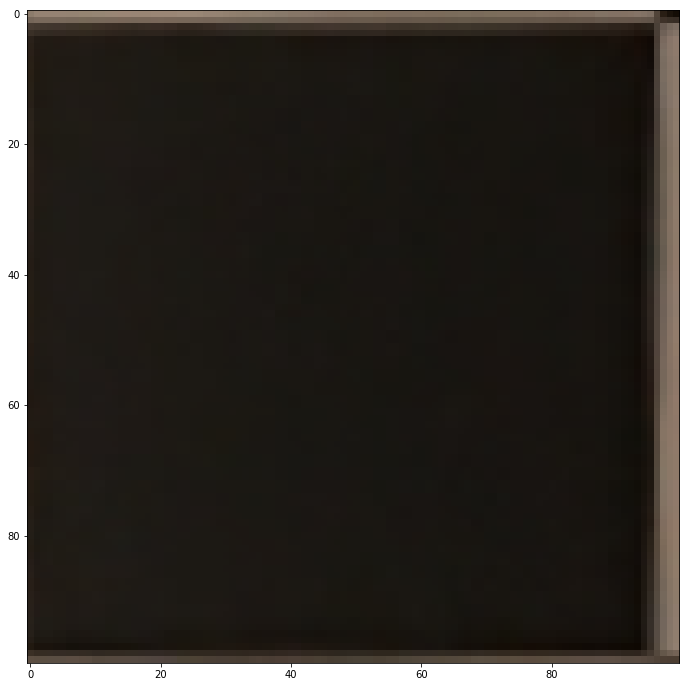

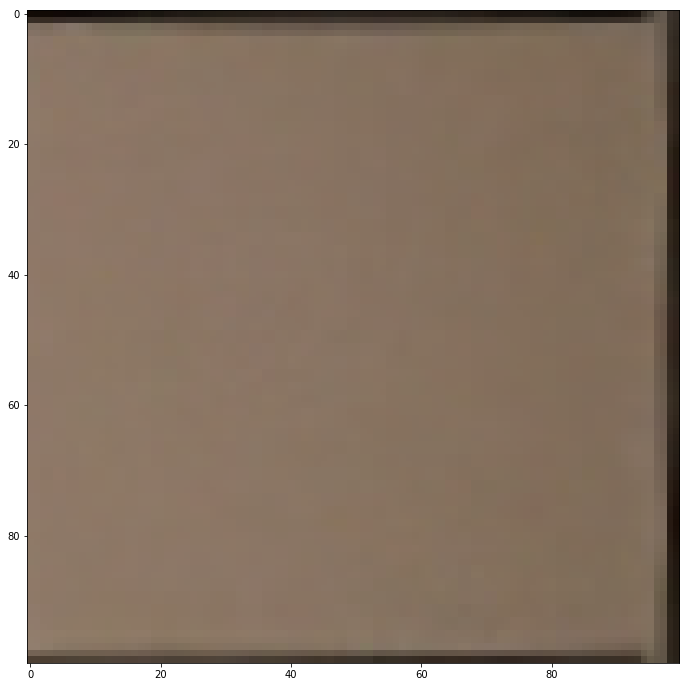

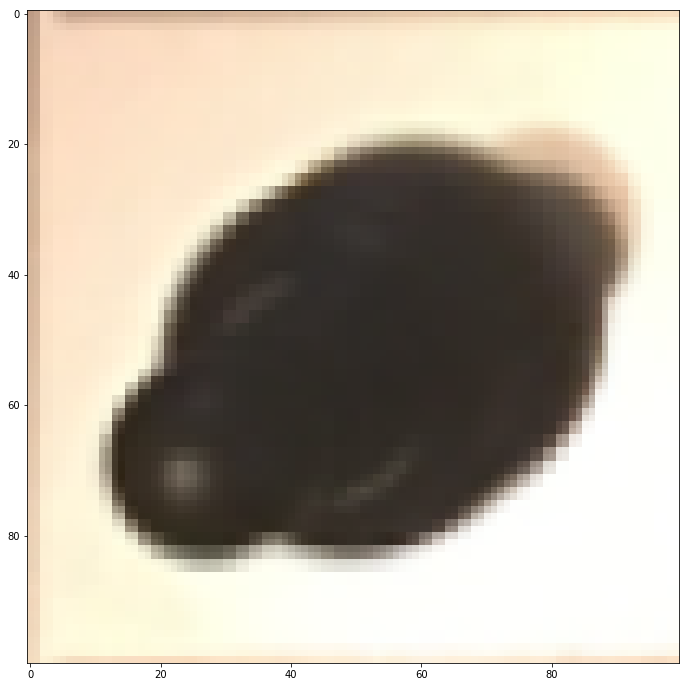

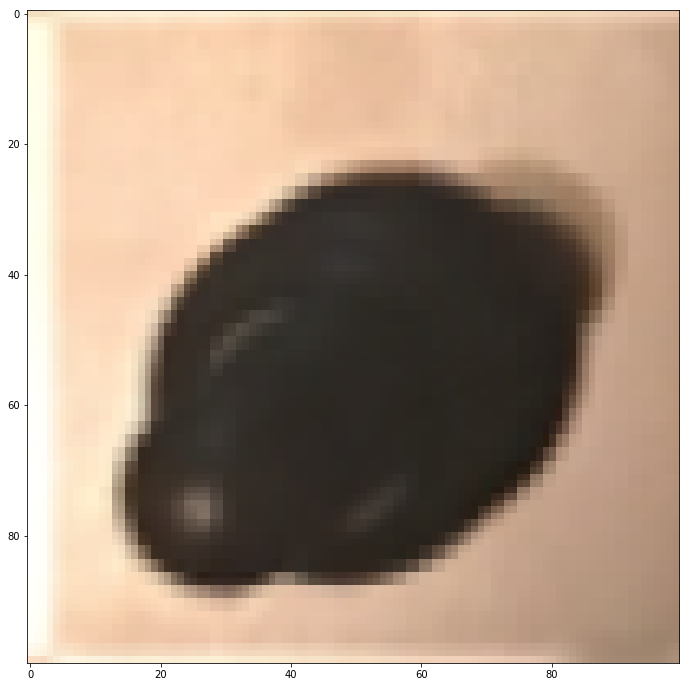

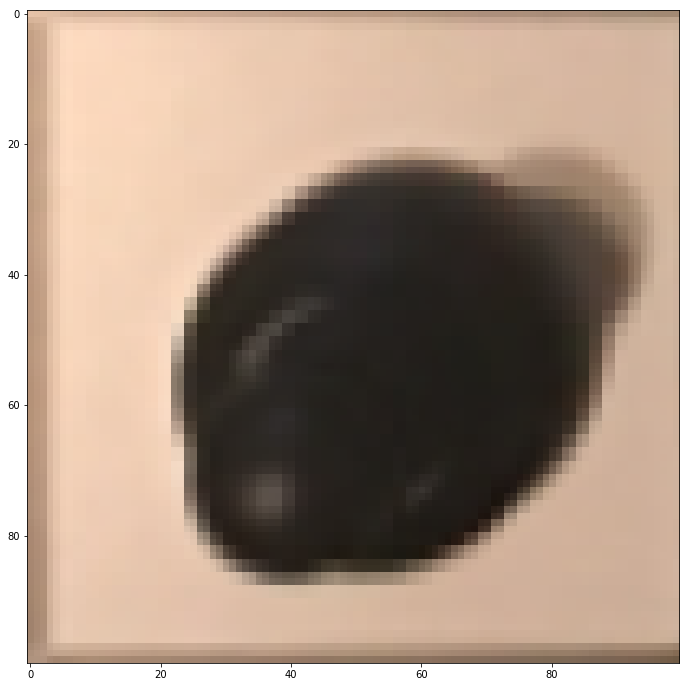

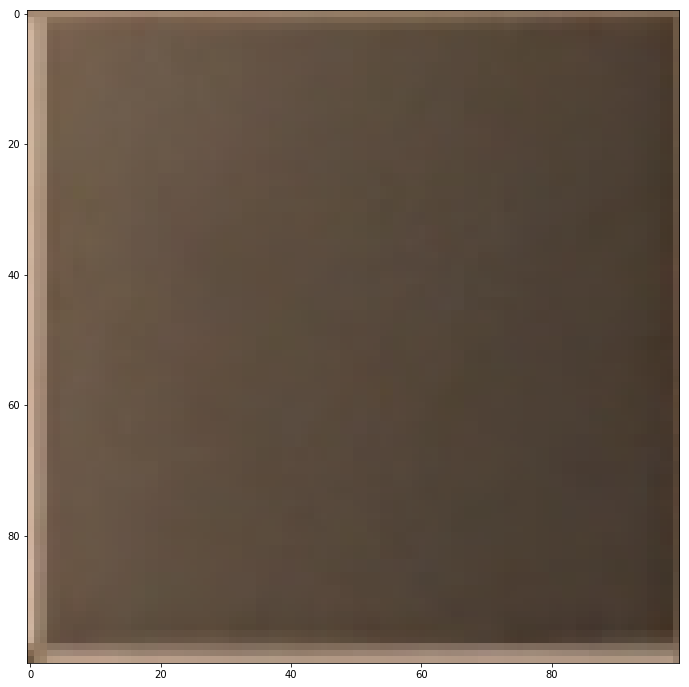

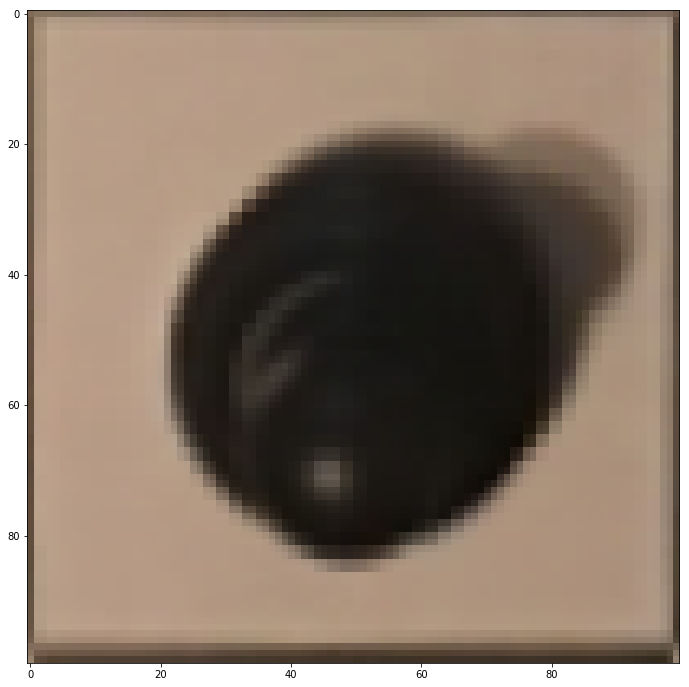

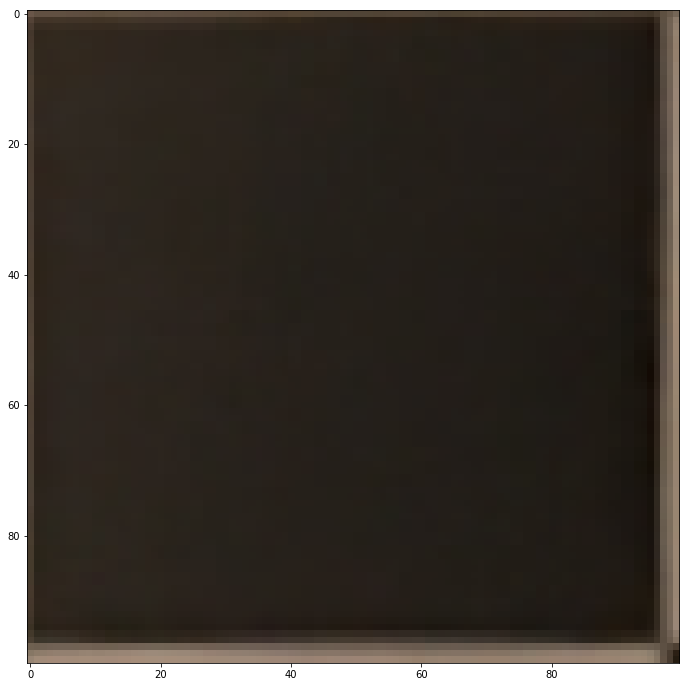

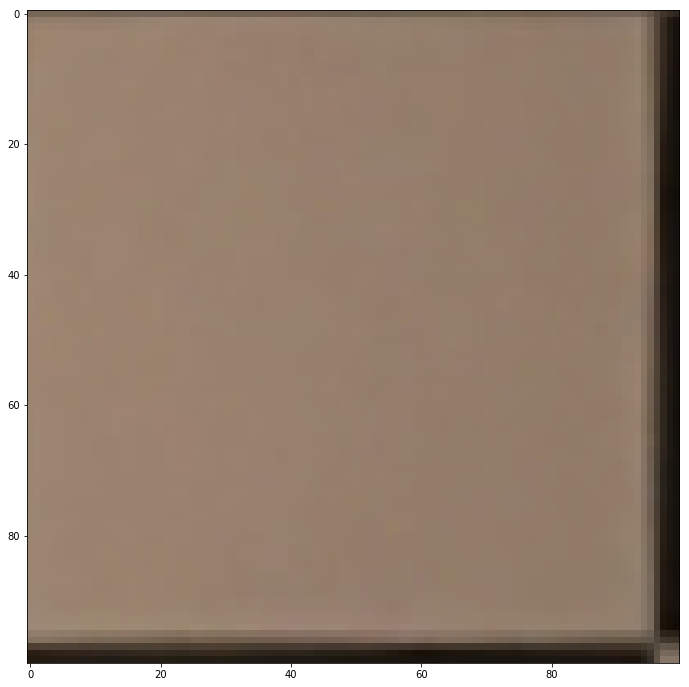

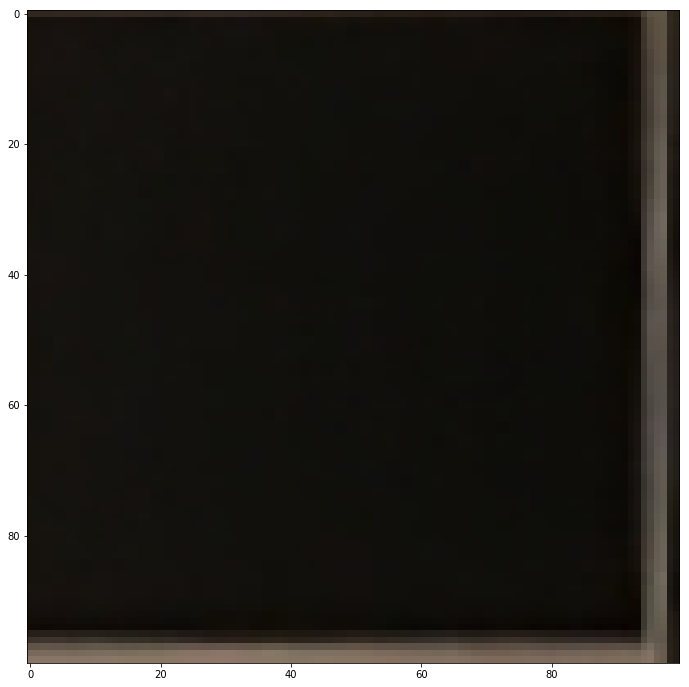

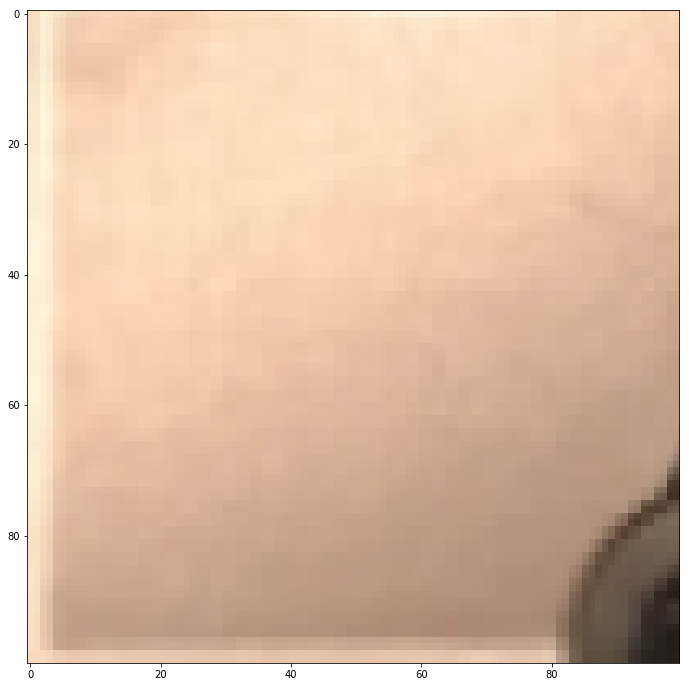

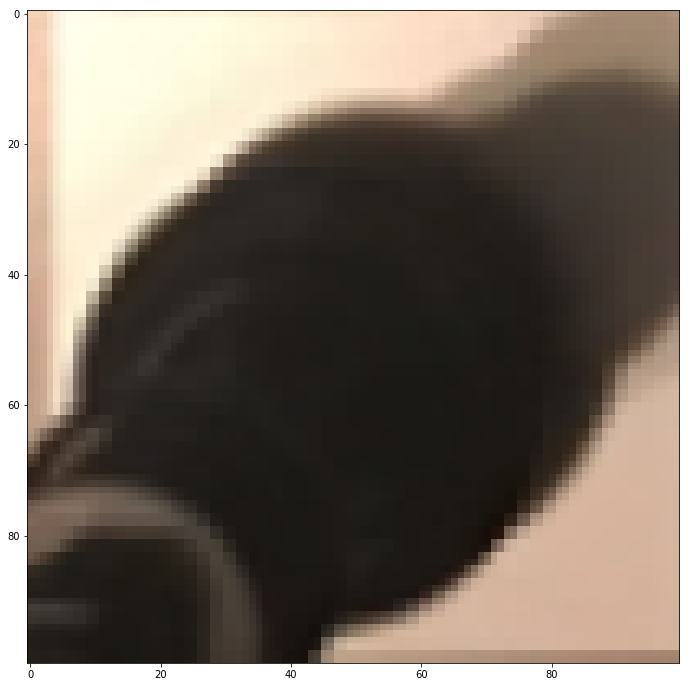

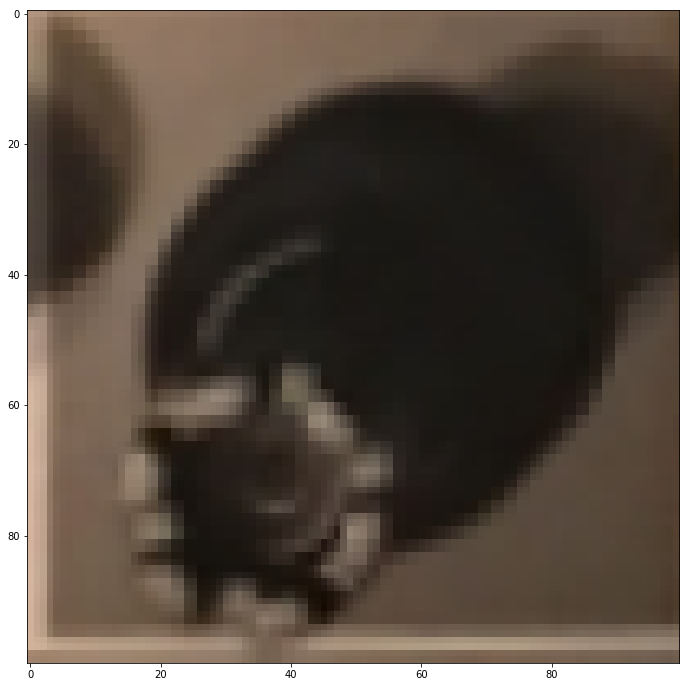

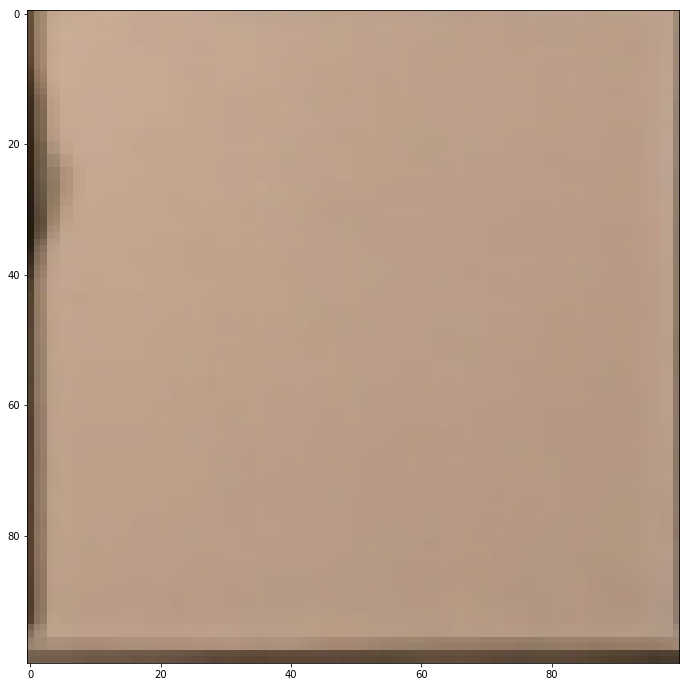

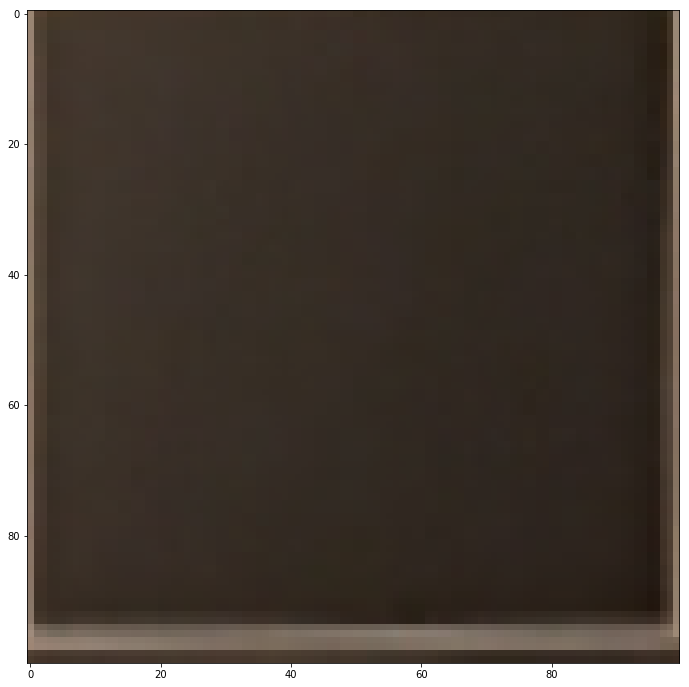

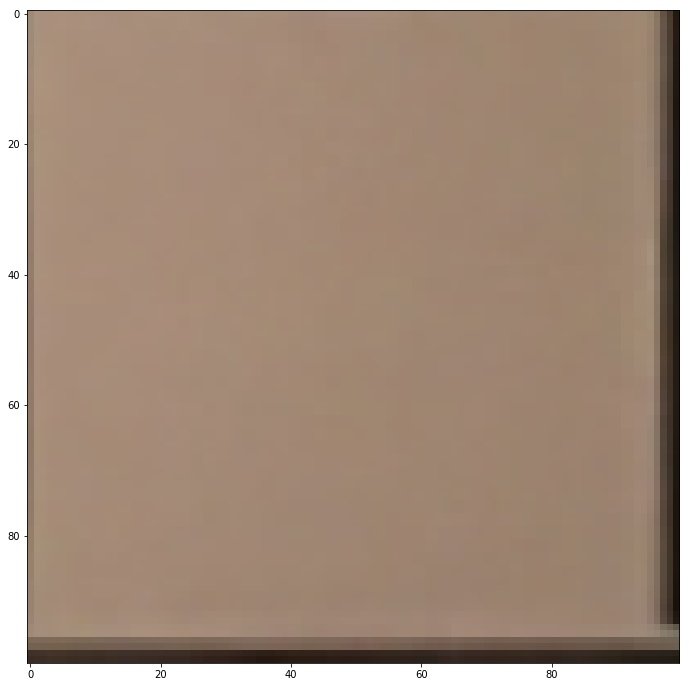

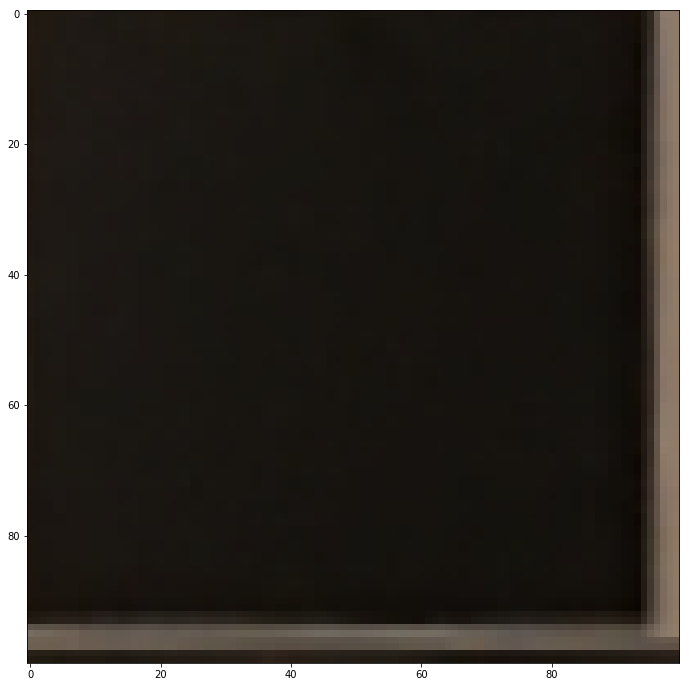

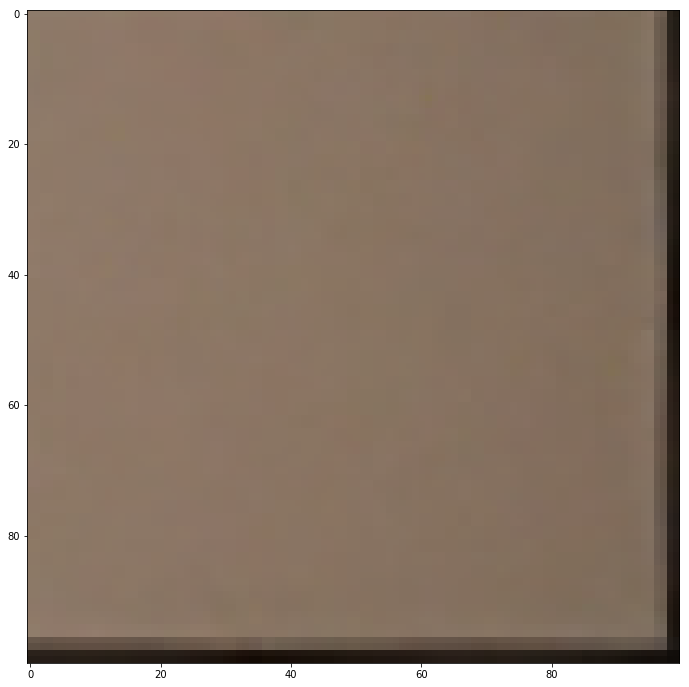

In [102]:
for i in range(8):
    for j in range(8):
        plt.imshow(squares[i][j])
        plt.show()

## 9. For each square

### a. Check if square is occupied

### b. If occupied, determine piece color

### c. Determine difference between `B[t-1]` and `B[t]` to compute `delta_matrix[i][j]`

## 10. If needed, handle piece promotion